<a href="https://www.kaggle.com/code/lucasfuller96/store-sales-using-lgbmregressor?scriptVersionId=171653850" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from xgboost import XGBRegressor

import datetime

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

from lightgbm import LGBMRegressor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 # Import and View Datasets

In [3]:
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

## Train - Summary
* The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
* store_nbr identifies the store at which the products are sold.
* family identifies the type of product sold.
* sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [4]:
train['date'] = train['date'].astype('datetime64[ns]')
test['date'] = test['date'].astype('datetime64[ns]')

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [7]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           3000888 non-null  int64         
 1   date         3000888 non-null  datetime64[ns]
 2   store_nbr    3000888 non-null  int64         
 3   family       3000888 non-null  object        
 4   sales        3000888 non-null  float64       
 5   onpromotion  3000888 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [8]:
print(f'There are {len(train.family.unique())} different Product Families')
print(f'There are {len(train.store_nbr.unique())} different Stores')

There are 33 different Product Families
There are 54 different Stores


In [9]:
product_families = train['family'].unique()

In [10]:
train[['family']].value_counts()

family                    
AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
C

In [11]:
train[['store_nbr']].value_counts()

store_nbr
1            55572
41           55572
30           55572
31           55572
32           55572
33           55572
34           55572
35           55572
36           55572
37           55572
38           55572
39           55572
40           55572
42           55572
2            55572
43           55572
44           55572
45           55572
46           55572
47           55572
48           55572
49           55572
50           55572
51           55572
52           55572
53           55572
29           55572
28           55572
27           55572
26           55572
3            55572
4            55572
5            55572
6            55572
7            55572
8            55572
9            55572
10           55572
11           55572
12           55572
13           55572
14           55572
15           55572
16           55572
17           55572
18           55572
19           55572
20           55572
21           55572
22           55572
23           55572
24           55572
25

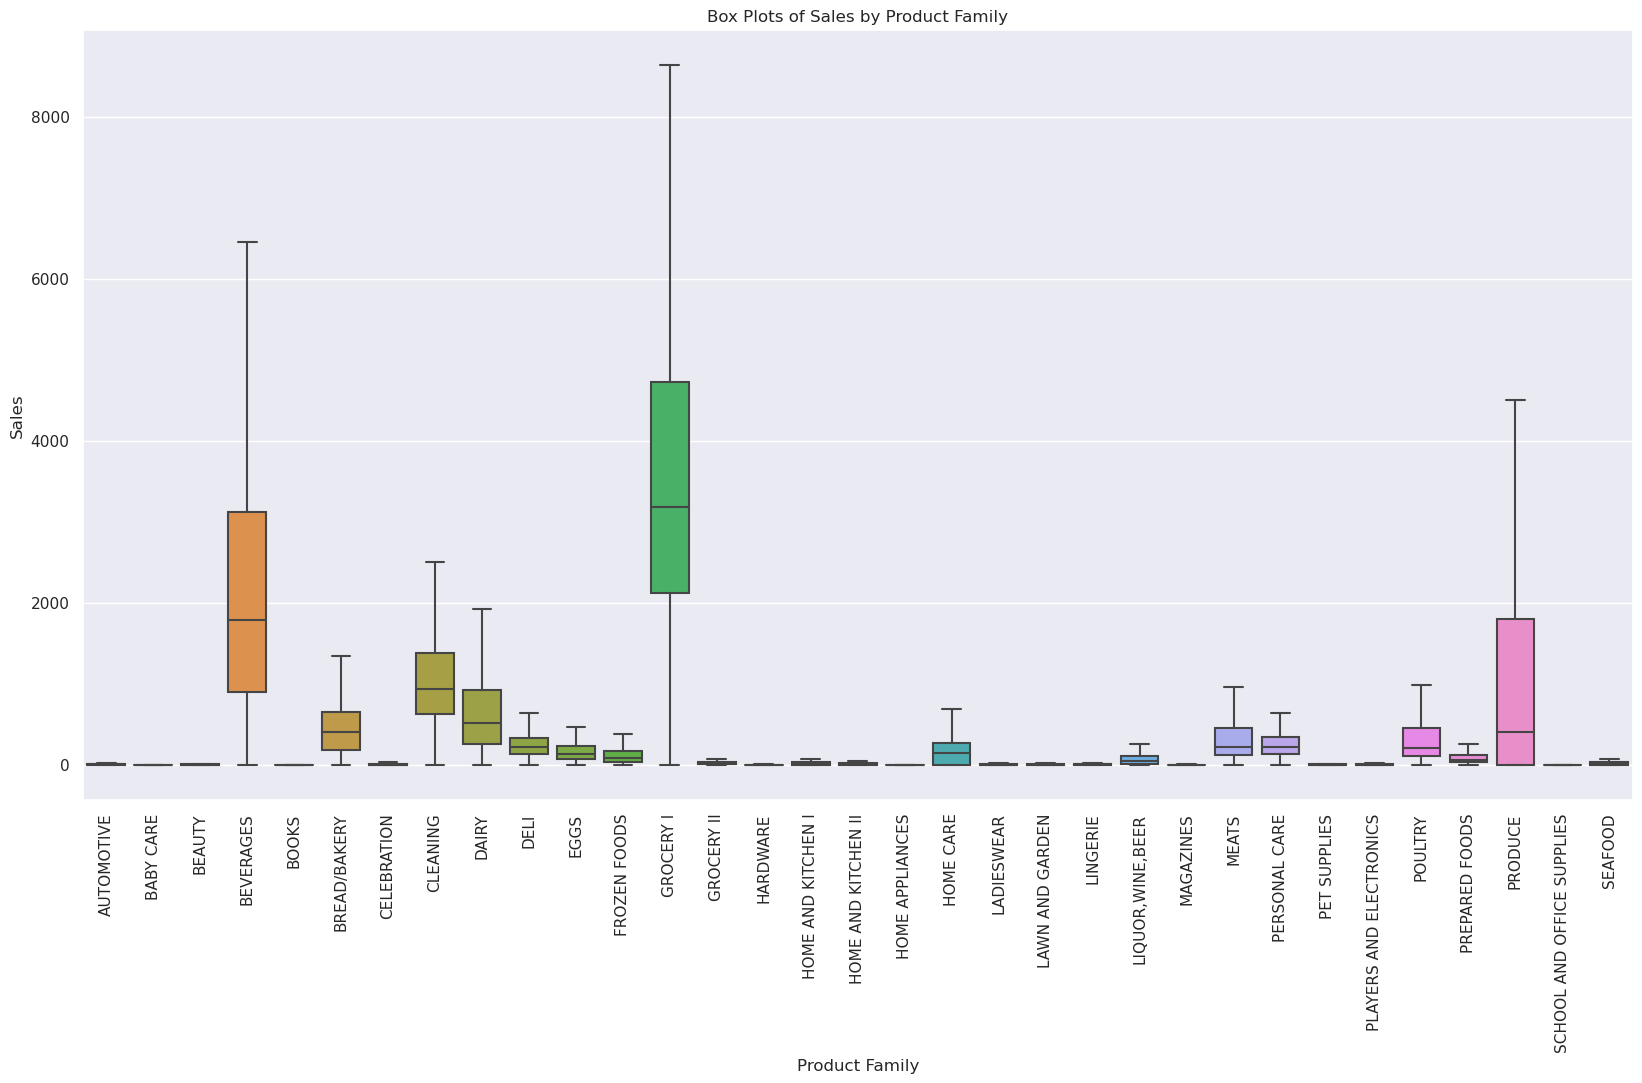

In [12]:
plt.figure(figsize=(20,10))
sns.boxplot(x=train['family'], y=train['sales'], showfliers = False)

plt.xticks(rotation=90)
plt.xlabel('Product Family')
plt.ylabel('Sales')

plt.title('Box Plots of Sales by Product Family')

plt.show()

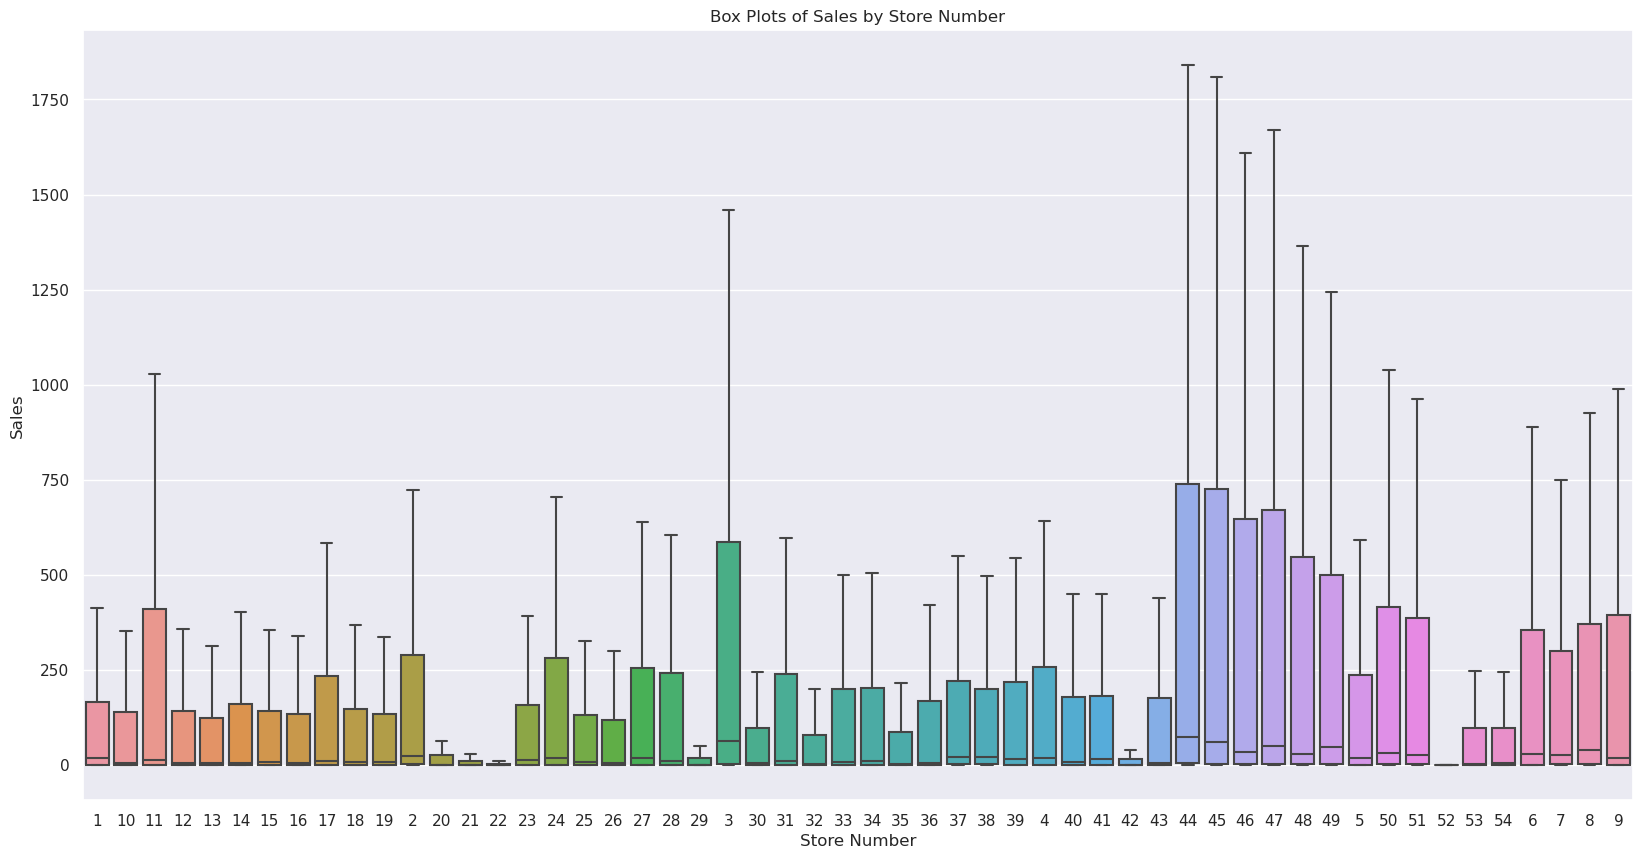

In [13]:
plt.figure(figsize=(20,10))
sns.boxplot(x=train['store_nbr'].astype(str), y=train['sales'], showfliers = False)

plt.xlabel('Store Number')
plt.ylabel('Sales')

plt.title('Box Plots of Sales by Store Number')
plt.show()

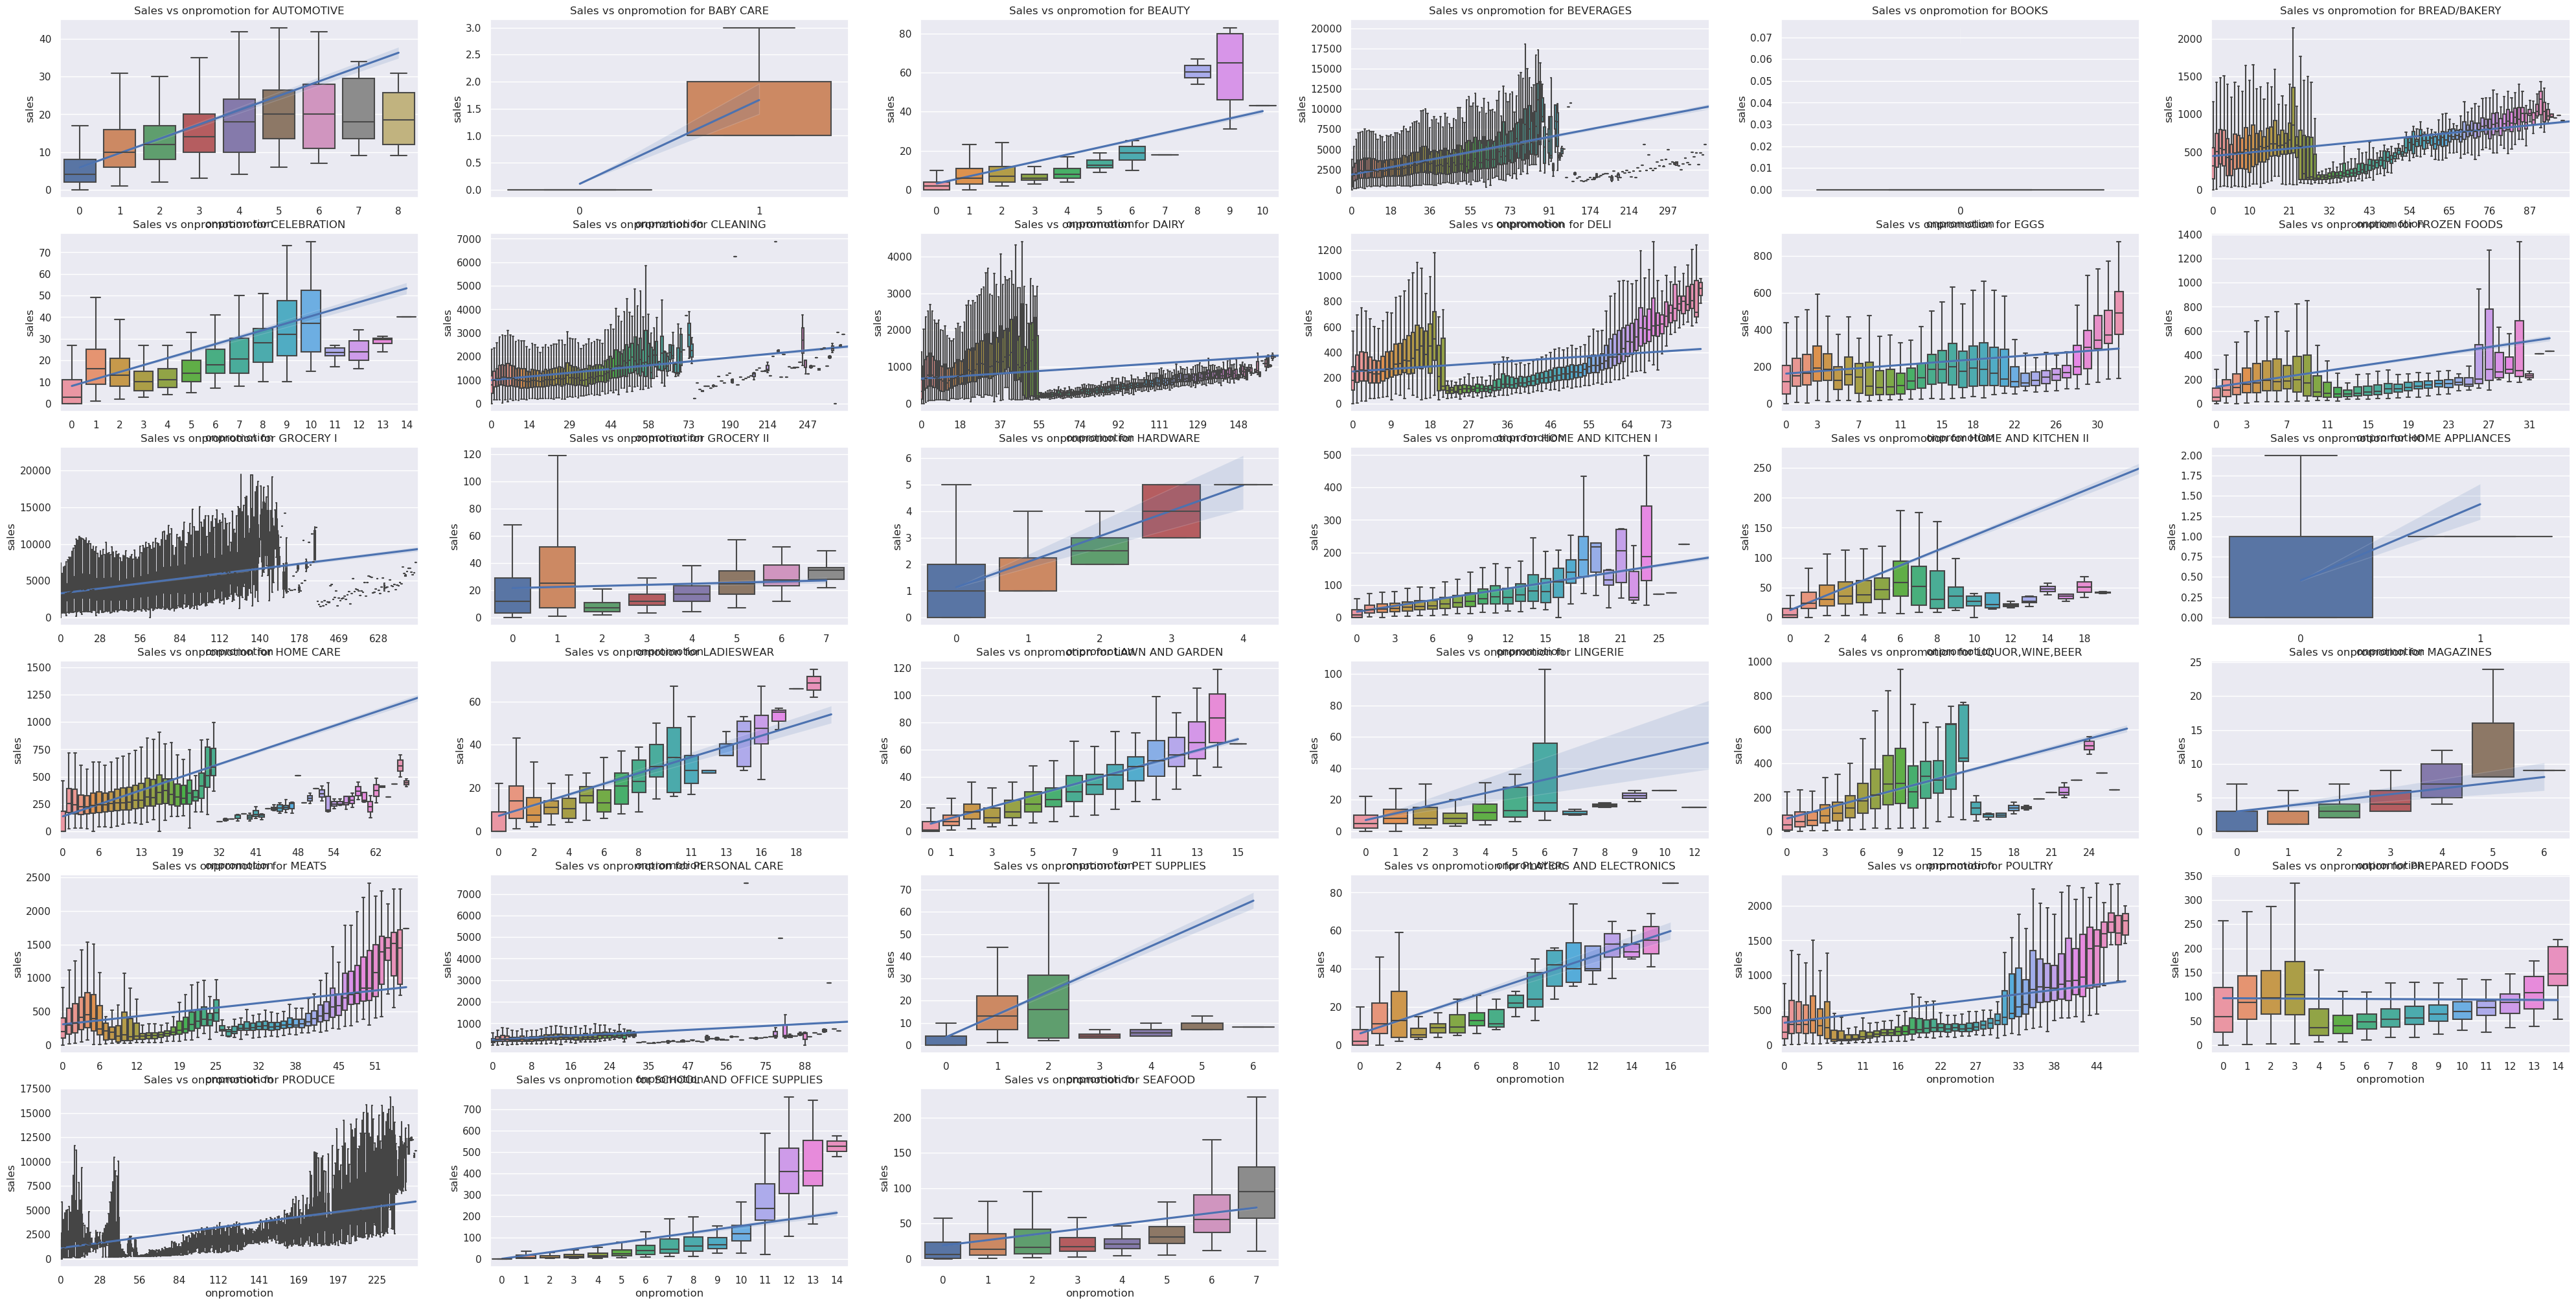

In [14]:
plt.figure(figsize=(50,25))

palette = sns.color_palette(None, len(product_families))


for n, family in enumerate(product_families):

    plt.subplot(6,6,n+1)
    
    family_mask = train['family'] == family
    
    sns.boxplot(x="onpromotion", y="sales", data=train[family_mask], showfliers = False)
    sns.regplot(x="onpromotion", y="sales", data=train[family_mask], scatter=False)
    
    x_max = len(train[family_mask]['onpromotion'].unique())
    
    plt.xlim([-0.5,x_max-0.5])
    
    if x_max > 15:
        plt.xticks(np.linspace(0,x_max+1,10,dtype=int))

    
    plt.title(f'Sales vs onpromotion for {family}')

plt.show()

In [15]:
promotions_mask = train['onpromotion'] > 0

promoitions_min = train[promotions_mask].date.min()
promoitions_max = train[promotions_mask].date.max()

print(f'Promotions Start Date: {promoitions_min}')
print(f'Promotions End Date: {promoitions_max}')


Promotions Start Date: 2014-04-01 00:00:00
Promotions End Date: 2017-08-15 00:00:00


In [16]:
print(f'Start Date: {train.date.min()}')
print(f'End Date: {train.date.max()}')
print(f'Number of Days: {len(train.date.unique())}')

Start Date: 2013-01-01 00:00:00
End Date: 2017-08-15 00:00:00
Number of Days: 1684


## Train - Insights
* We have no null data to deal with
* There are 33 different types of product family, and 54 different stores
* Both variables have the same number of rows for each family/store, so we're not missing historic data for some families/stores
* We can pull out features from data such as day of week/month/year to track temporal trends
* Sales by product family varies a lot more than store number, with 'Grocery I' being the largest seller. We might be best off with model product since the variance is so high so the models can learn the particular paterns of each family
* Store number still has a strong effect on sales so will make a useful feature
* There is a strong correlation between on promotion and sales, but the trend is quite different across product families, which is another justification for product specific models
* Data ranges from between 2013-01-01 and 2017-08-15
* Promotion data is only included from 2014-04-01 though, so we might be best off only using data from here

## Transactions - Summary
* Total transactions for each store by day

In [17]:
transactions['date'] = transactions['date'].astype('datetime64[ns]')

In [18]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [19]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [20]:
transactions.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


Axes(0.125,0.11;0.775x0.77)


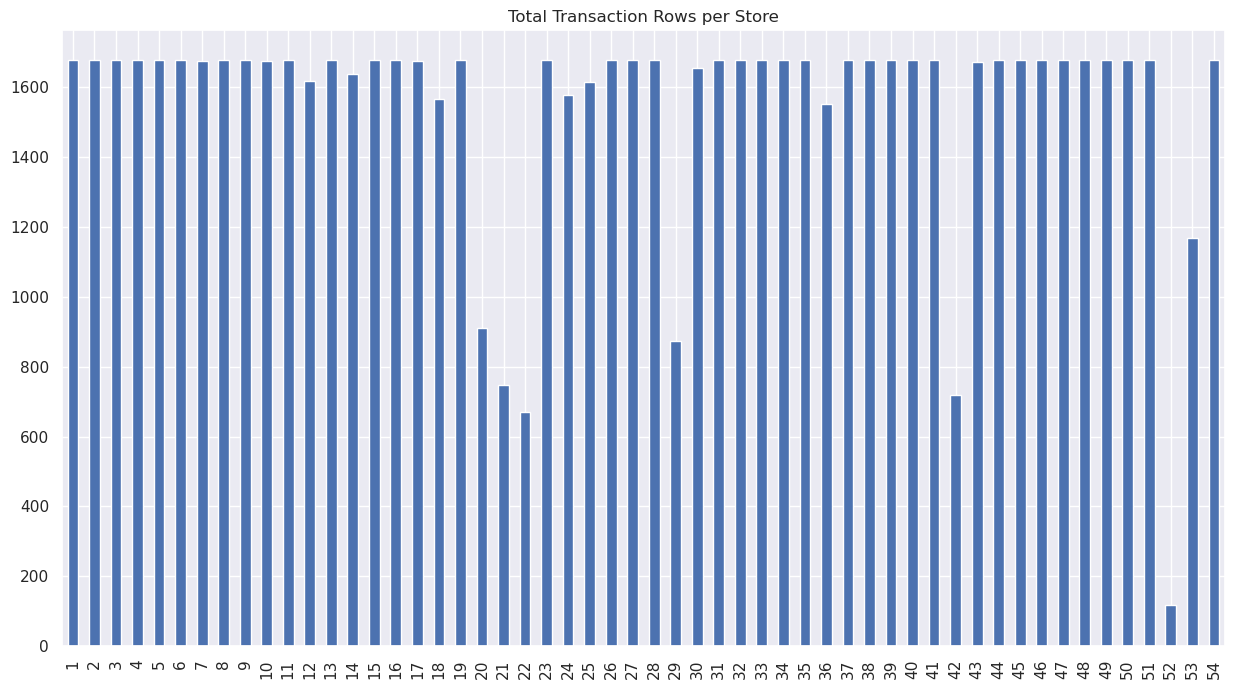

In [21]:
plt.figure(figsize=(15,8))

print(transactions['store_nbr'].value_counts().sort_index().plot(kind='bar'))

plt.title('Total Transaction Rows per Store')

plt.show()

In [22]:
print(f'Start Date: {transactions.date.min()}')
print(f'End Date: {transactions.date.max()}')
print(f'Number of Days: {len(transactions.date.unique())}')

Start Date: 2013-01-01 00:00:00
End Date: 2017-08-15 00:00:00
Number of Days: 1682


## Transactions - Insights
* We have a list of total transactions by store by day
* There's quite a range of transactions (minimum of 5 and maximum of 8359) per store/product
* We don't have any test data for transactions - so if we use lag features they'll need to be 16+ days in the past to be used in the test dataset
* We don't have the same amount of historic data from each store, and we're missing data from 2 days - we'll need to impute with zeros to fill these in

## Stores - Summary
* Store metadata, including city, state, type, and cluster.
* cluster is a grouping of similar stores.

In [23]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [24]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [25]:
stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


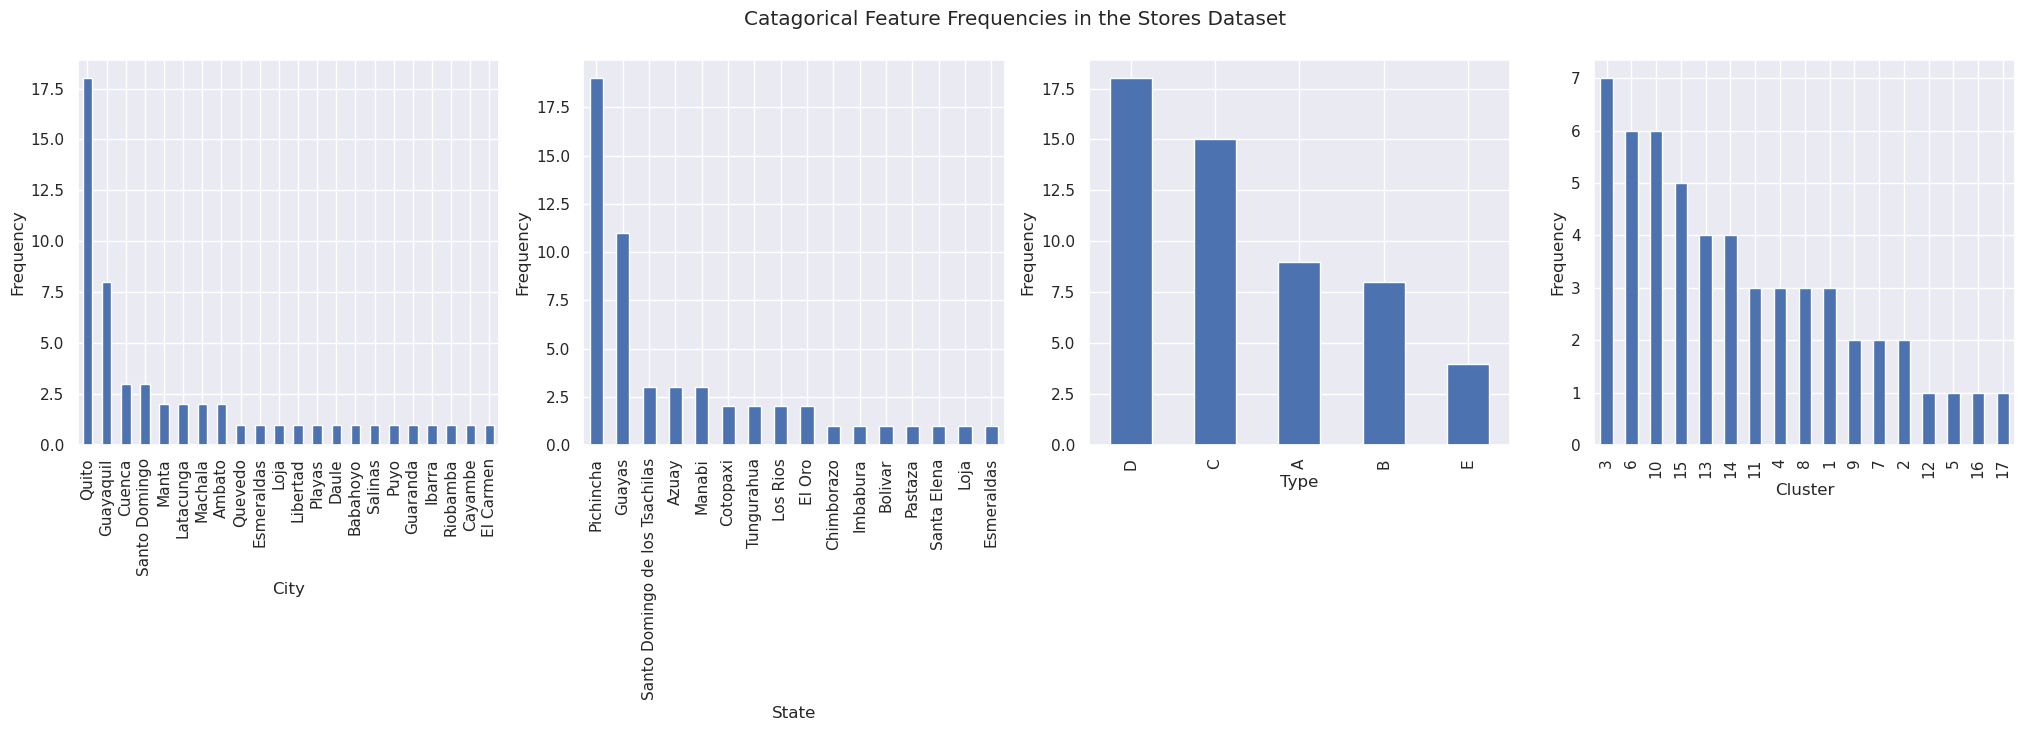

In [26]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
stores['city'].value_counts().plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Frequency')


plt.subplot(1,4,2)
stores['state'].value_counts().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Frequency')

plt.subplot(1,4,3)
stores['type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Frequency')


plt.subplot(1,4,4)
stores['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')


plt.suptitle('Catagorical Feature Frequencies in the Stores Dataset')

plt.show()

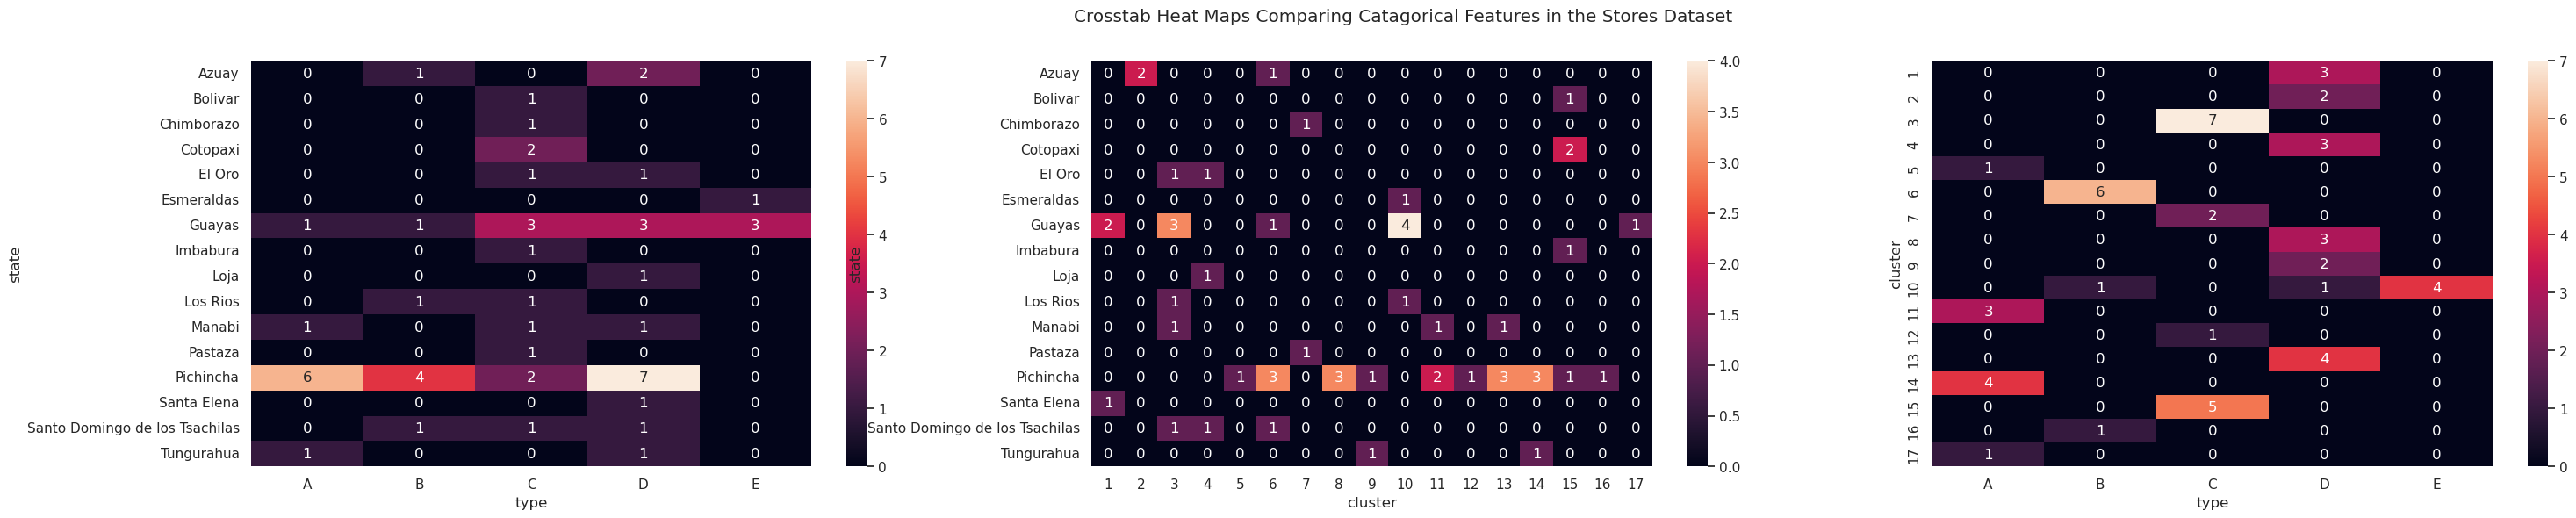

In [27]:
plt.figure(figsize=(35,6))

plt.subplot(1,3,1)
state_type_crosstab = pd.crosstab(stores['state'], stores['type'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of State vs Store Type')

plt.subplot(1,3,2)
state_type_crosstab = pd.crosstab(stores['state'], stores['cluster'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of State vs Cluster')

plt.subplot(1,3,3)
state_type_crosstab = pd.crosstab(stores['cluster'], stores['type'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Type vs Cluster')

plt.suptitle('Crosstab Heat Maps Comparing Catagorical Features in the Stores Dataset')

plt.show()

In [28]:
sales_store = train.merge(stores, how='left', on='store_nbr')

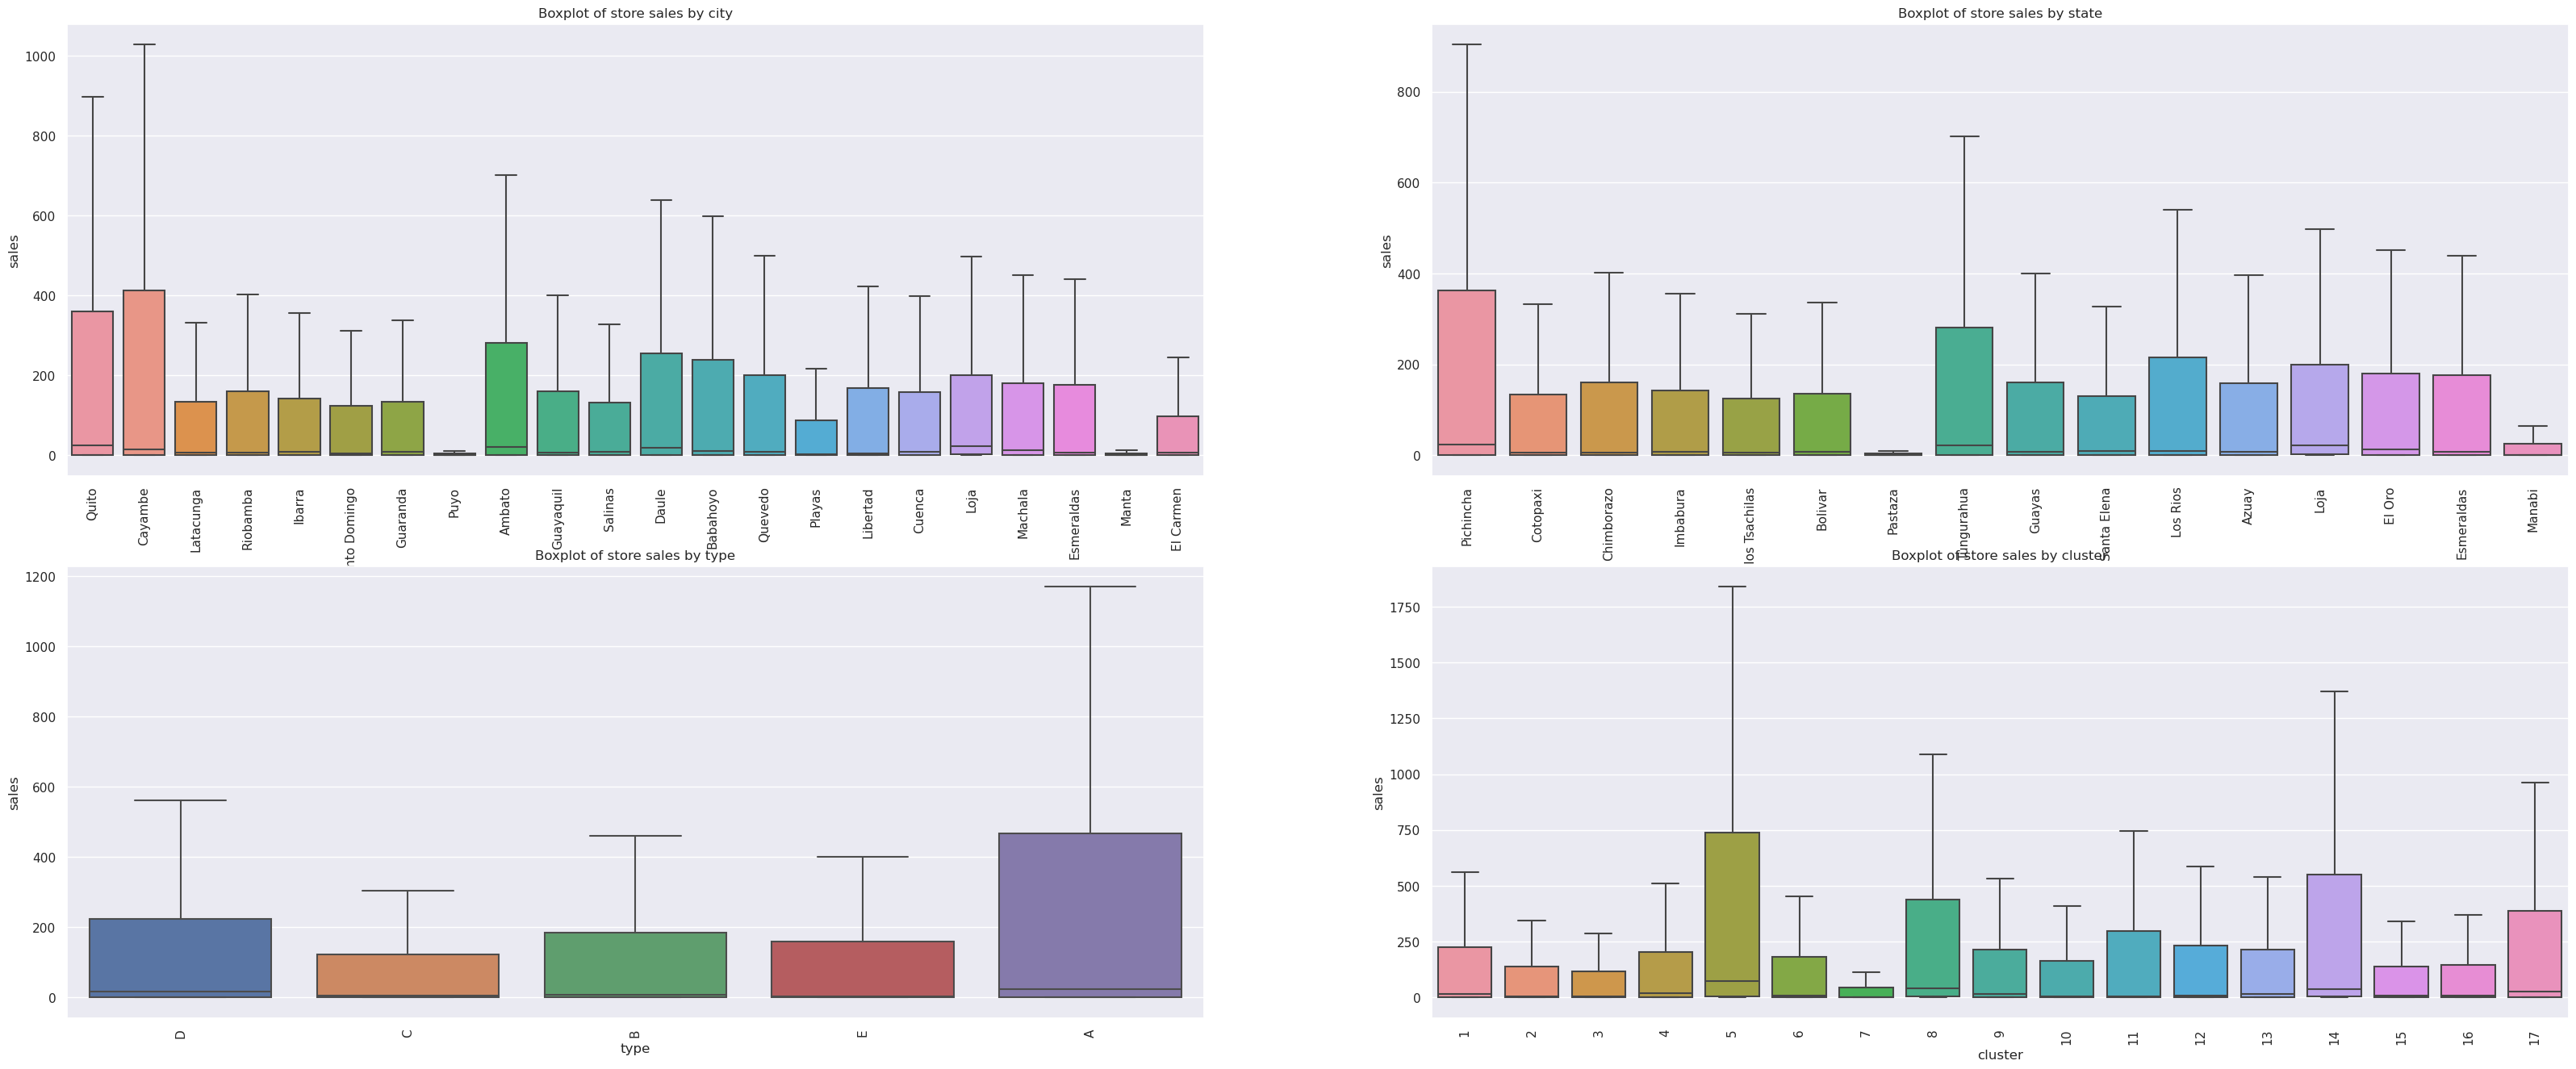

In [29]:
plt.figure(figsize=(40,16))

plt.subplot(2,2,1)
sns.boxplot(x=sales_store['city'], y=sales_store['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by city')

plt.subplot(2,2,2)
sns.boxplot(x=sales_store['state'], y=sales_store['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by state')

plt.subplot(2,2,3)
sns.boxplot(x=sales_store['type'], y=sales_store['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by type')

plt.subplot(2,2,4)
sns.boxplot(x=sales_store['cluster'], y=sales_store['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by cluster')

plt.show()

## Stores - Insight
* Again, no nulls
* There are 54 stores, each belonging to one of 17 clusters and 5 types
* The most frequent city is Quito, which is the only city in Pichincha
* There's not much of a correlation between State and Type or State and Cluster, i.e. the type and cluster are spread amongst the states
* There is a strong correlation between cluster and type (there's only one cluster which has a mix of types - cluster 10), so for most cases stores in the same cluster are of the same type

## Holiday - Summary
* Holidays and Events, with metadata
* NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
* Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [30]:
holidays_events['date'] = holidays_events['date'].astype('datetime64[ns]')

In [31]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [32]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [33]:
holidays_events.describe()

/tmp/ipykernel_20/1017088249.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  holidays_events.describe()


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25 00:00:00,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338
first,2012-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2017-12-26 00:00:00,NaN,NaN,NaN,NaN,NaN


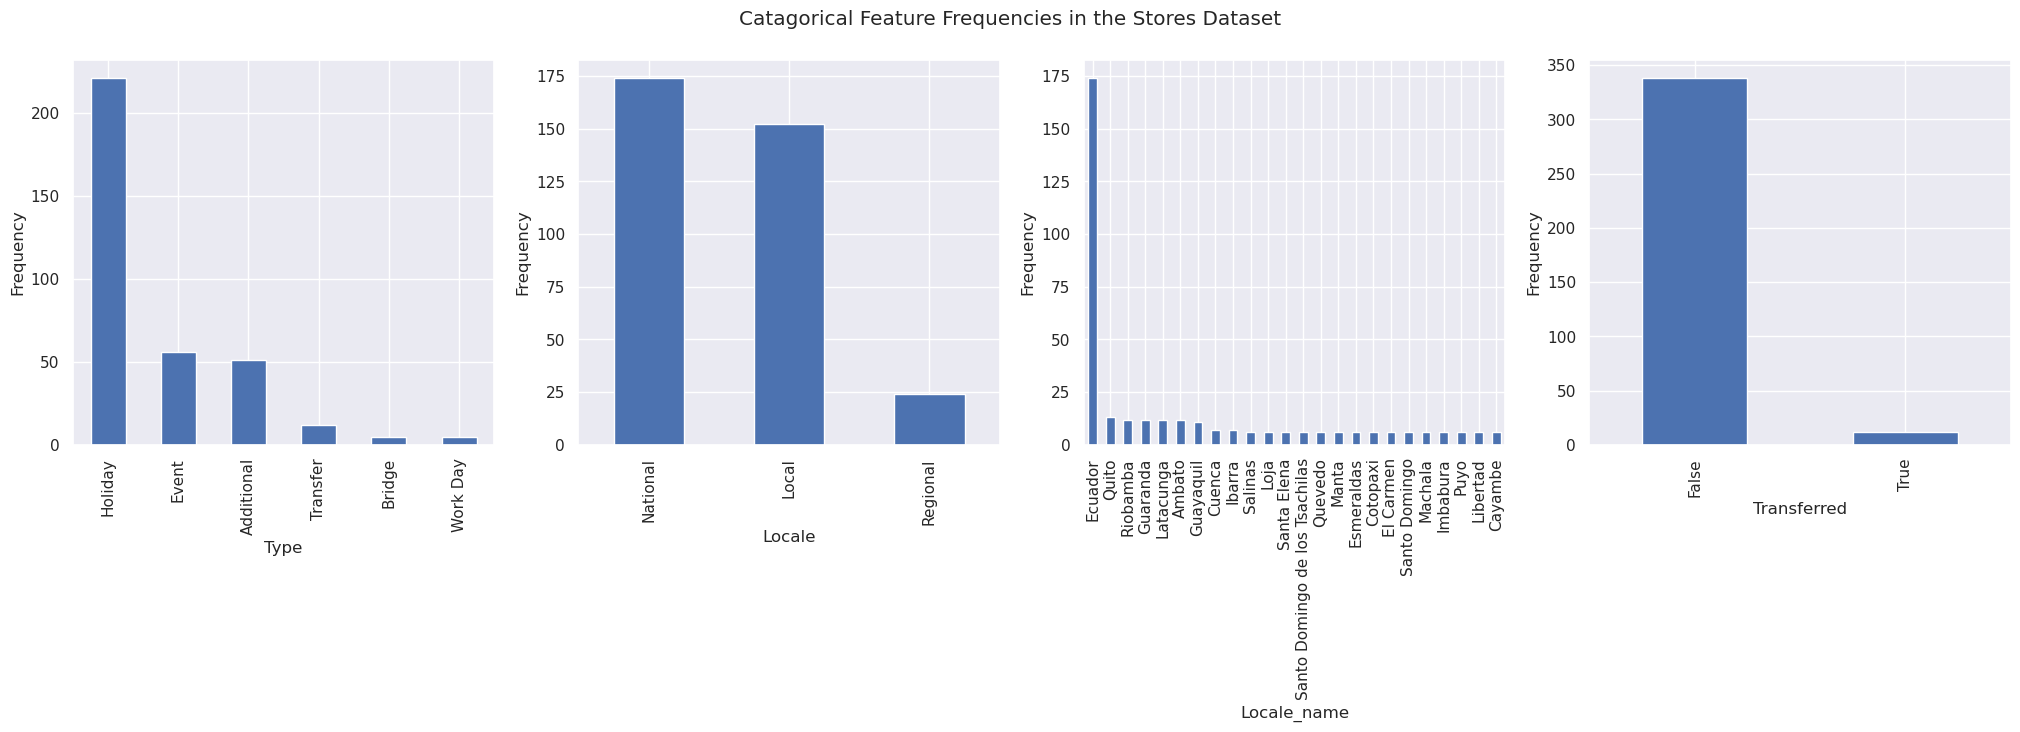

In [34]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
holidays_events['type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Frequency')


plt.subplot(1,4,2)
holidays_events['locale'].value_counts().plot(kind='bar')
plt.xlabel('Locale')
plt.ylabel('Frequency')

plt.subplot(1,4,3)
holidays_events['locale_name'].value_counts().plot(kind='bar')
plt.xlabel('Locale_name')
plt.ylabel('Frequency')


plt.subplot(1,4,4)
holidays_events['transferred'].value_counts().plot(kind='bar')
plt.xlabel('Transferred')
plt.ylabel('Frequency')


plt.suptitle('Catagorical Feature Frequencies in the Stores Dataset')

plt.show()

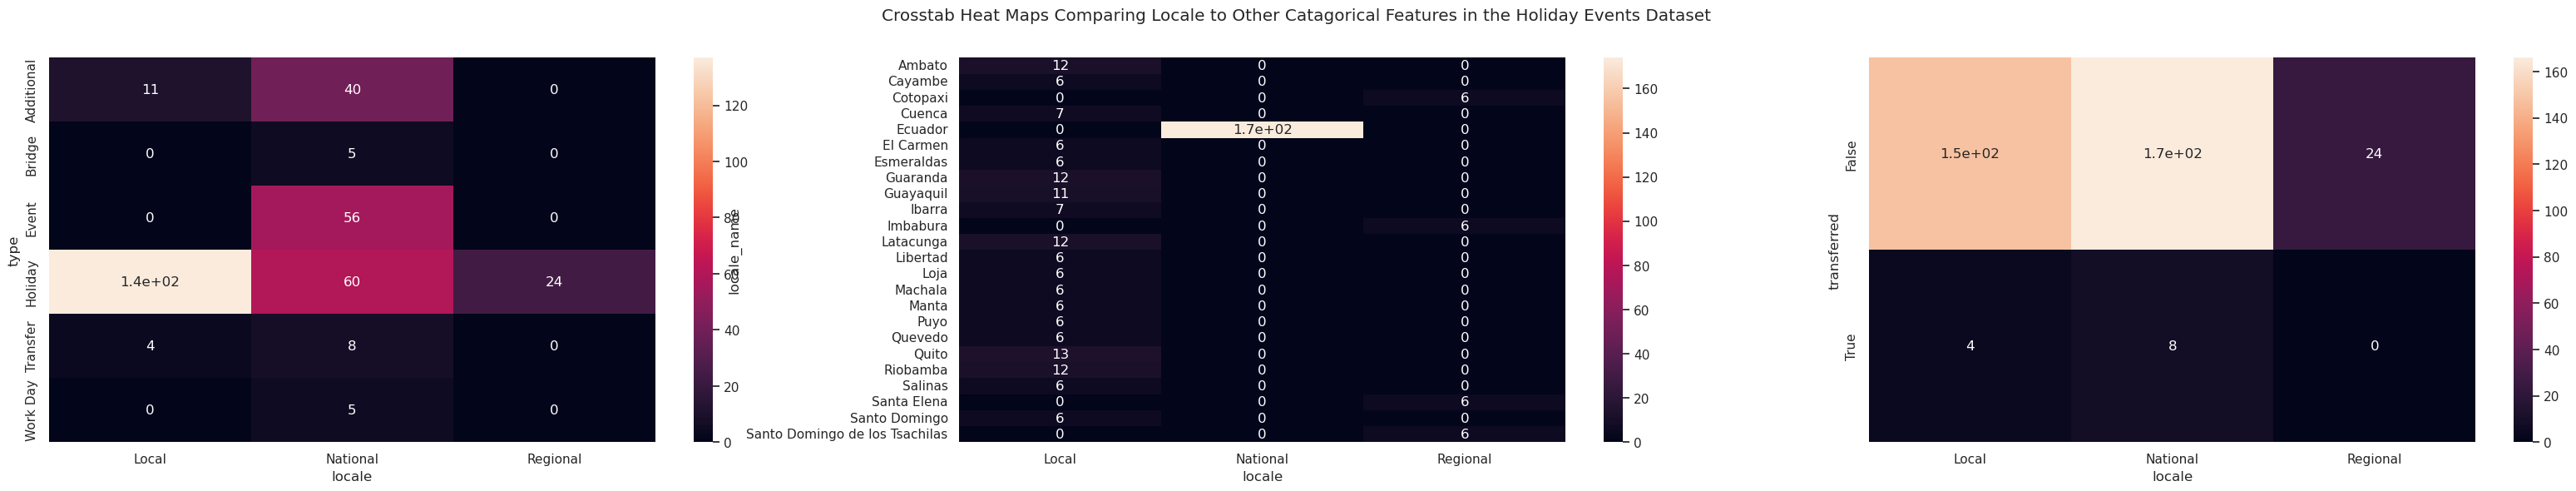

In [35]:
plt.figure(figsize=(40,6))

plt.subplot(1,3,1)
state_type_crosstab = pd.crosstab(holidays_events['type'], holidays_events['locale'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Type vs Locale')

plt.subplot(1,3,2)
state_type_crosstab = pd.crosstab(holidays_events['locale_name'], holidays_events['locale'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Locale Name vs Locale')


plt.subplot(1,3,3)
state_type_crosstab = pd.crosstab(holidays_events['transferred'], holidays_events['locale'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Transferred vs Locale')

plt.suptitle('Crosstab Heat Maps Comparing Locale to Other Catagorical Features in the Holiday Events Dataset')

plt.show()

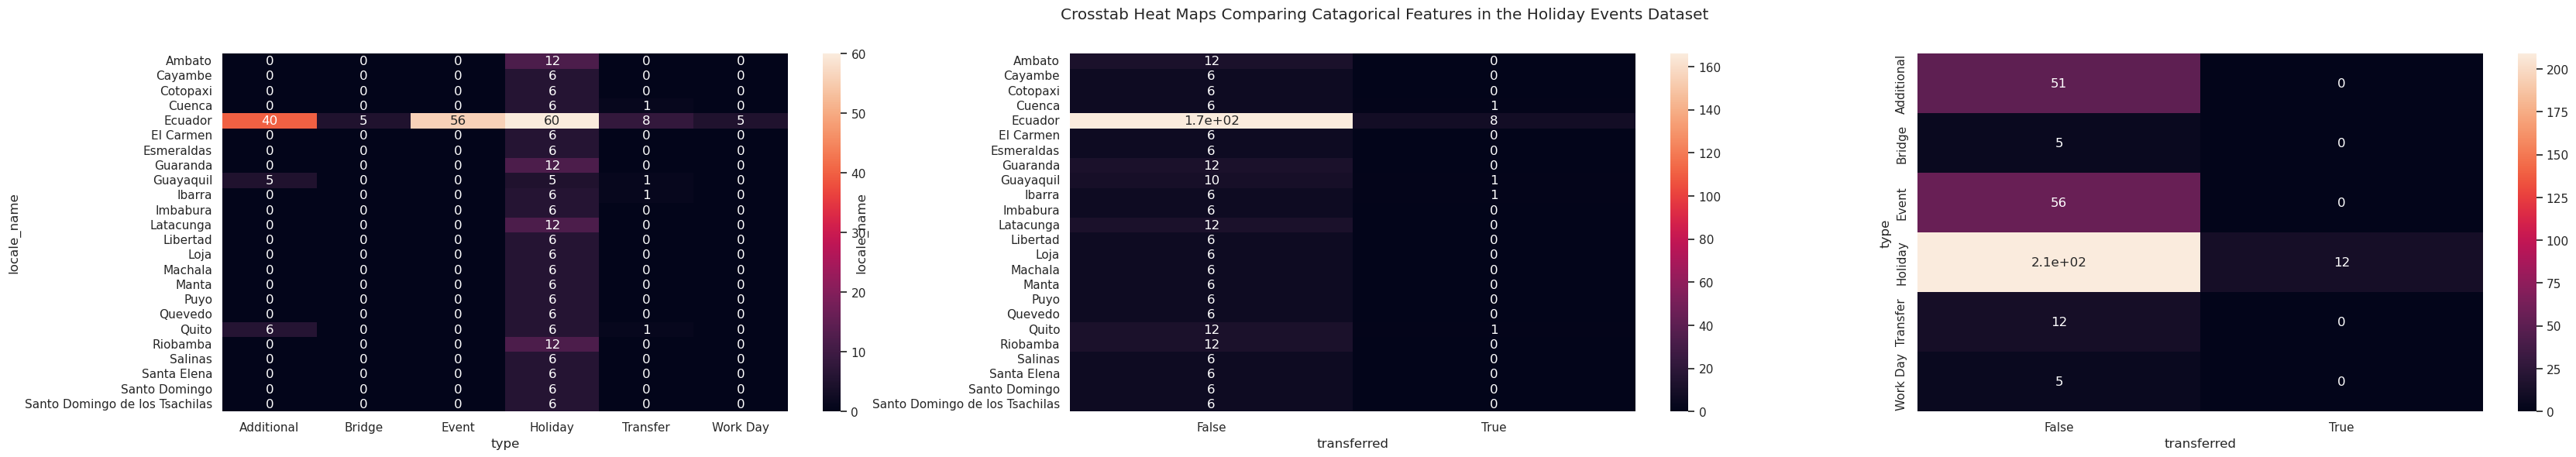

In [36]:
plt.figure(figsize=(40,6))

plt.subplot(1,3,1)
state_type_crosstab = pd.crosstab(holidays_events['locale_name'], holidays_events['type'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Locale Name vs Type')

plt.subplot(1,3,2)
state_type_crosstab = pd.crosstab(holidays_events['locale_name'], holidays_events['transferred'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Locale Name vs Trasnferred')


plt.subplot(1,3,3)
state_type_crosstab = pd.crosstab(holidays_events['type'], holidays_events['transferred'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Type vs Trasnferred')

plt.suptitle('Crosstab Heat Maps Comparing Catagorical Features in the Holiday Events Dataset')

plt.show()

In [37]:
print(holidays_events['date'].min())
print(holidays_events['date'].max())

2012-03-02 00:00:00
2017-12-26 00:00:00


## Holiday - Insights
* No Null
* Looks like me might be able to use the first word of the 'description' column as a feature
* We need to handle the date based on the transfered column - we might want to use the original transfered data too somewhere, or keep the flag
* if Locale = 'local' this links to city in 'stores' dataset
* if Locale = 'Regional' this links to state in 'stores' dataset
* if Locale = 'National' this applies to all stores
* Ecuador has by far the most holidays, other than them, no other locale_names have 'National Locale' holidays
* All Transferered holidays/events are of type 'Holiday'
* We have holiday data into the test period so we don't need to worry about working out which days are holidays
* For simplicity we'll just look at regional holdays for now

# Oil - Summary
* Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [38]:
oil['date'] = oil['date'].astype('datetime64[ns]')


In [39]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [40]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [41]:
oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [42]:
sales_oil = train.groupby(['date']).mean('sales').merge(oil, how='left', on='date')
pearson_correlation = sales_oil.corr().loc['sales','dcoilwtico']

/tmp/ipykernel_20/2926103236.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_correlation = sales_oil.corr().loc['sales','dcoilwtico']


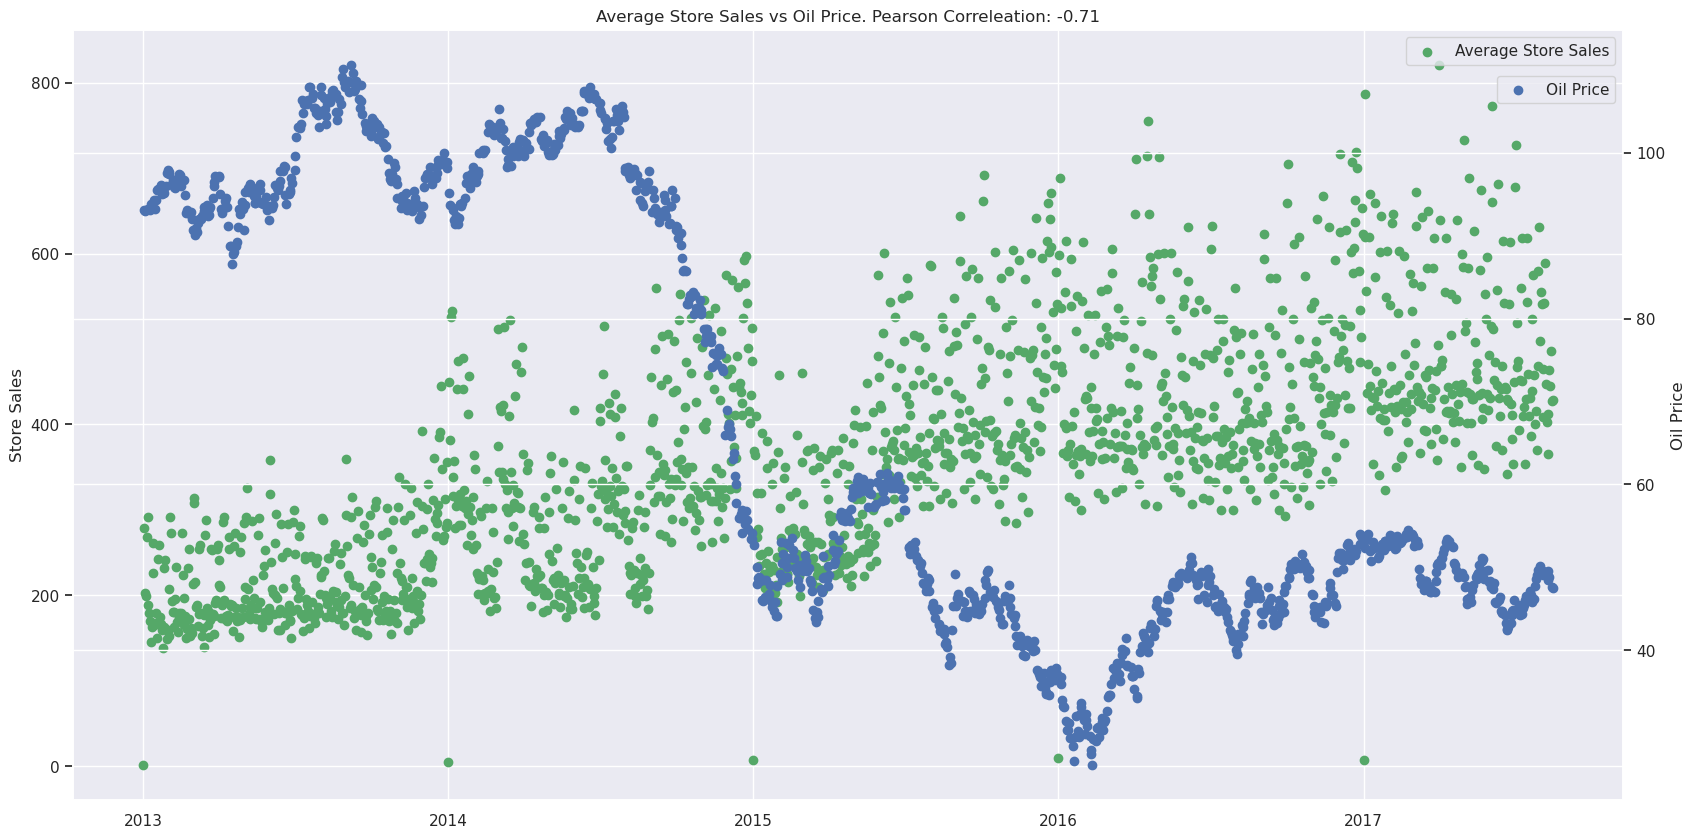

In [43]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()

ax1.scatter(sales_oil['date'], sales_oil['sales'], color="g", label='Average Store Sales')
ax1.set_ylabel('Store Sales')

ax2.scatter(sales_oil['date'], sales_oil['dcoilwtico'], color="b", label='Oil Price')
ax2.set_ylabel('Oil Price')

ax1.legend(bbox_to_anchor=(1,1))
ax2.legend(bbox_to_anchor=(1,0.95))

plt.title(f'Average Store Sales vs Oil Price. Pearson Correleation: {pearson_correlation:.2f}')
plt.show()

In [44]:
print(oil['date'].min())
print(oil['date'].max())

2013-01-01 00:00:00
2017-08-31 00:00:00


## Oil - Insight
* We have 73 Null values to deal with, we may be able to take a moving average to fill these
* We have a fairly strong negative correlelation between store sales and oil price so this will make a useful feature


# Feature Engineering

## Train/Test
* Create date featues (e.g. year/month/weekday etc)
* Rather than set a payday flag, use day of month as this will naturally include trends for how long after pay day that sales are increased
* create lag sales features

In [45]:
# add dummy sales column to test so we can concat
test['sales'] = 0
train_test = pd.concat([train,test])

In [46]:
train_test['date'] = train_test['date'].astype('datetime64[ns]')
train_test['year'] = train_test['date'].dt.year
train_test['dayofyear'] = train_test['date'].dt.dayofyear
train_test['quarter'] = train_test['date'].dt.quarter
train_test['weekofyear'] = train_test['date'].dt.weekofyear
train_test['weekday'] = train_test['date'].dt.dayofweek
train_test['month'] = train_test['date'].dt.month
train_test['day'] = train_test['date'].dt.day

/tmp/ipykernel_20/4098933903.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_test['weekofyear'] = train_test['date'].dt.weekofyear


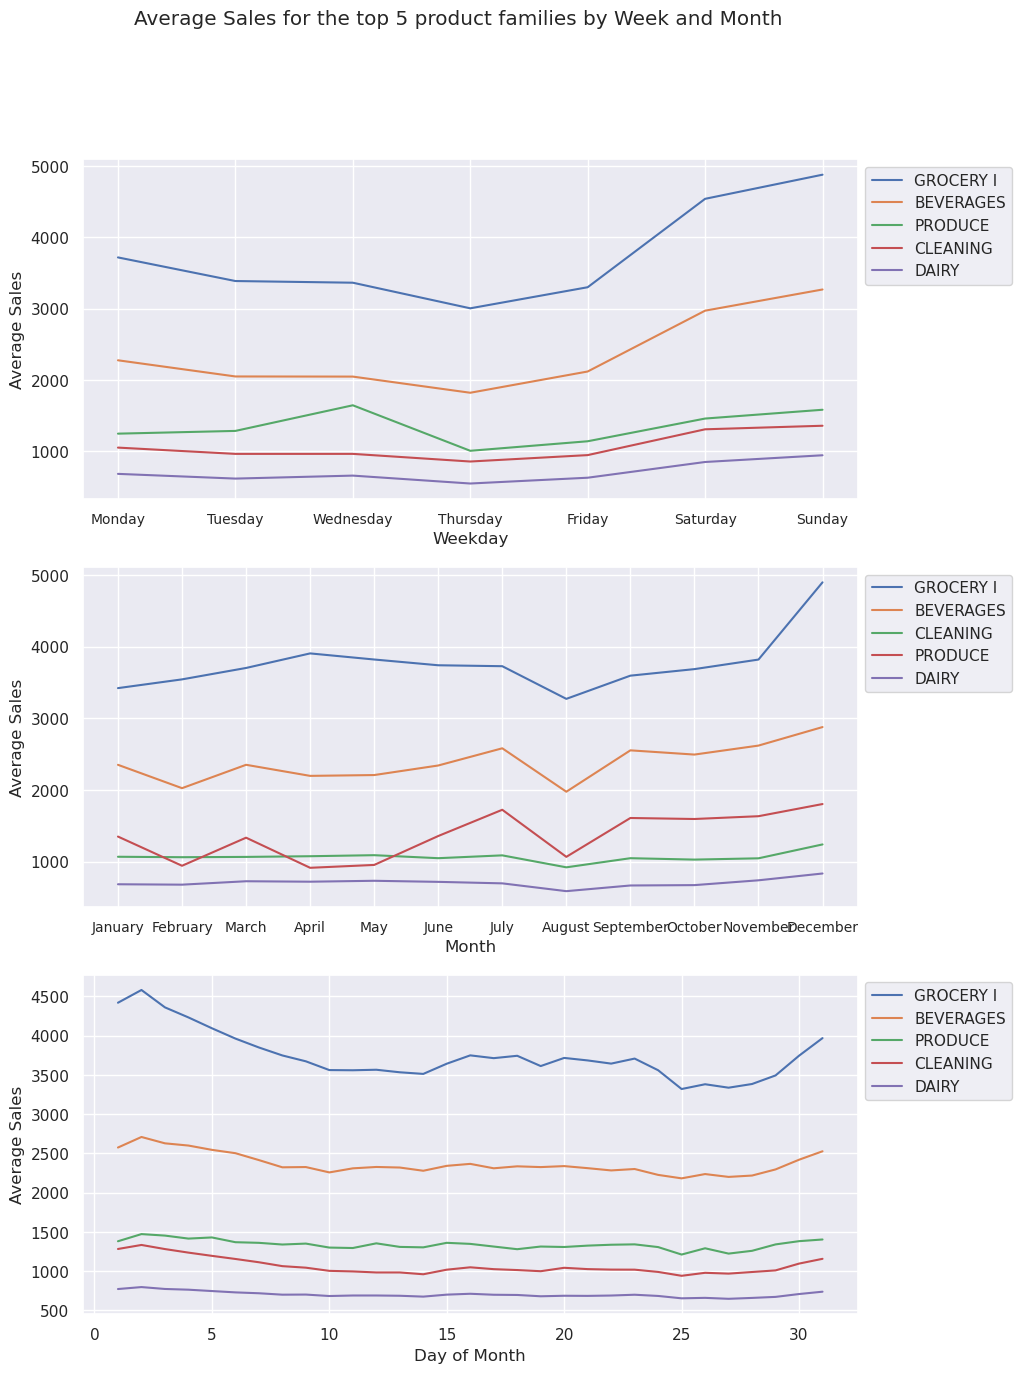

In [47]:
# Plot Average Sales for top 5 product families by day of week and month to show how they are affected 
weekday_sales_by_family = pd.crosstab(index = train_test['family'], columns=train_test['weekday'], values=train_test['sales'], aggfunc='mean').sort_values(by=[0], ascending=False).iloc[0:5,:]
month_sales_by_family = pd.crosstab(index = train_test['family'], columns=train_test['month']-1, values=train_test['sales'], aggfunc='mean').sort_values(by=[1], ascending=False).iloc[0:5,:]
day_of_month_sales_by_family = pd.crosstab(index = train_test['family'], columns=train_test['day'], values=train_test['sales'], aggfunc='mean').sort_values(by=[1], ascending=False).iloc[0:5,:]

weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10,15))


# plot weeks
plt.subplot(3,1,1)
for w_f in weekday_sales_by_family.iterrows():
    
    plt.plot(w_f[1], label=w_f[0])
                            
plt.xticks(range(len(weekdays)), weekdays, size='small')
plt.ylabel('Average Sales')
plt.xlabel('Weekday')
plt.legend(bbox_to_anchor=(1,1))

# plot months
plt.subplot(3,1,2)
for m_f in month_sales_by_family.iloc[0:5,:].iterrows():
    
    plt.plot(m_f[1], label=m_f[0])
                            
plt.xticks(range(len(months)), months, size='small')
plt.ylabel('Average Sales')
plt.xlabel('Month')
plt.legend(bbox_to_anchor=(1,1))

# plot day of month
plt.subplot(3,1,3)
for m_f in day_of_month_sales_by_family.iterrows():
    
    plt.plot(m_f[1], label=m_f[0])
                            
plt.ylabel('Average Sales')
plt.xlabel('Day of Month')
plt.legend(bbox_to_anchor=(1,1))

plt.suptitle('Average Sales for the top 5 product families by Week and Month')

plt.show()


In [48]:
# look at autocorrelation
train_mean = train[['date','sales']].groupby(['date']).mean()

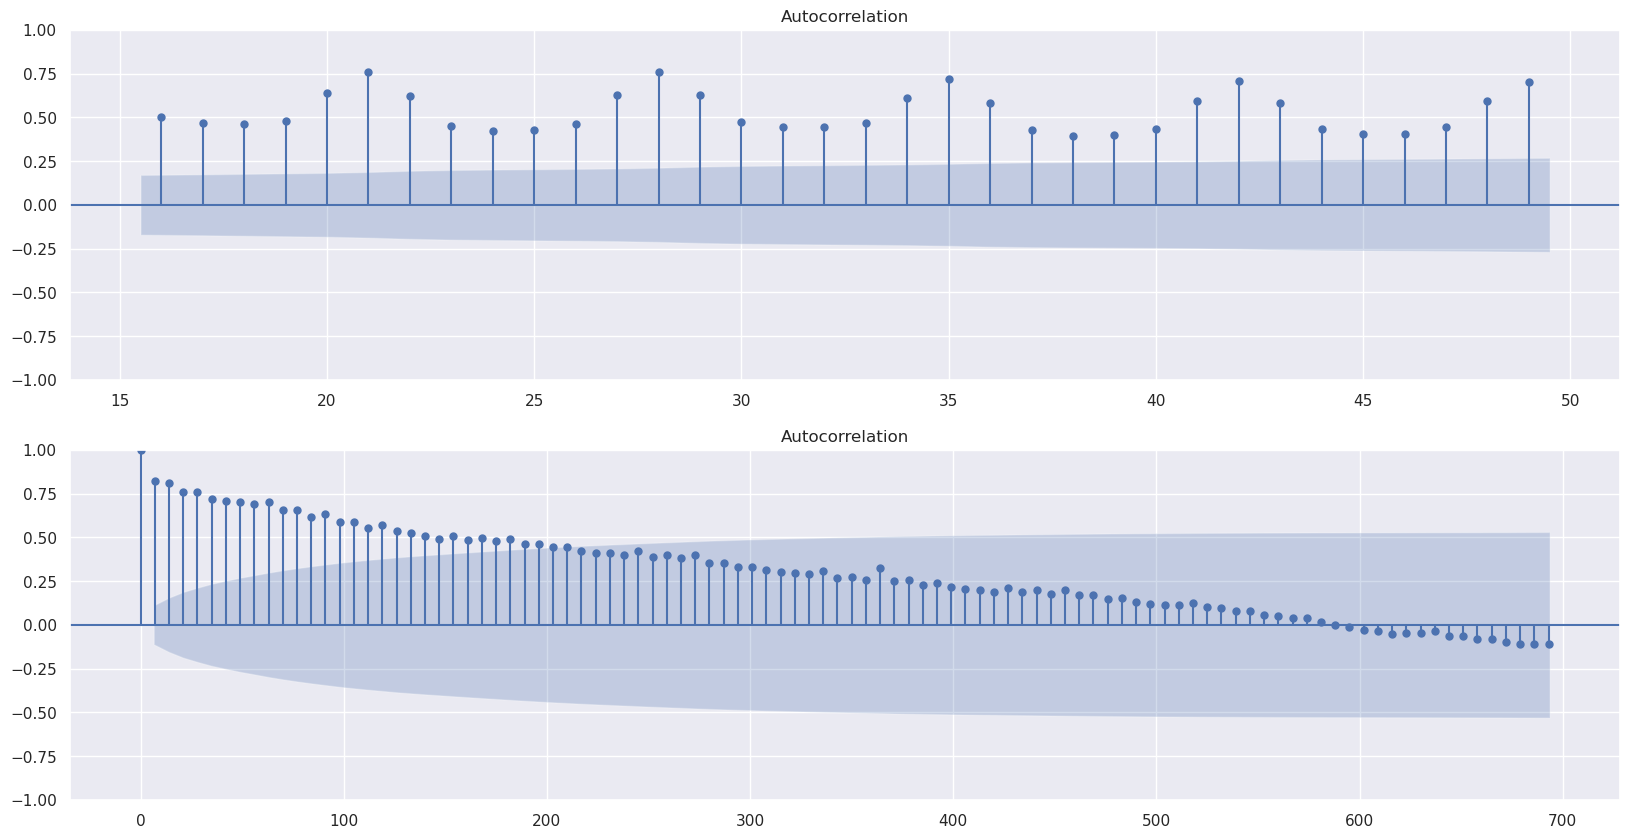

In [49]:
fig, ax = plt.subplots(2, figsize=(20, 10))

plot_acf(train_mean, lags=np.arange(16,50,1), alpha=0.05, ax=ax[0]);

plot_acf(train_mean, lags=np.arange(0,700,7), alpha=0.05, ax=ax[1]);
plt.show()

In [50]:
# use the below lags
train_lags = [16,17,18,21,28,35,42]

In [51]:
store_nbrs = train['store_nbr'].unique()
families = train['family'].unique()

In [52]:
# create lag features
for store in store_nbrs:

    for family in families:
    
        store_family_index = (train_test['store_nbr'] == store) & (train_test['family'] == family)
        
        
        for lag in train_lags:
    
            train_test.loc[store_family_index,f'transactions-{lag}'] = train_test.loc[store_family_index,'sales'].shift(lag)

## Transactions
* Add lag features

In [53]:
date_dummy = pd.DataFrame(pd.date_range(start=train['date'].min(), end=test['date'].max()), columns=['date'])
store_nbr_dummy = pd.DataFrame(store_nbrs, columns=['store_nbr'])

transactions_dummy = date_dummy.merge(store_nbr_dummy, how='cross')

transactions = transactions_dummy.merge(transactions, how='left', left_on=['date','store_nbr'], right_on=['date','store_nbr']).fillna(0)

In [54]:
# Look at autocorrelation
transactions_mean = transactions[['date','transactions']].groupby(['date']).mean()

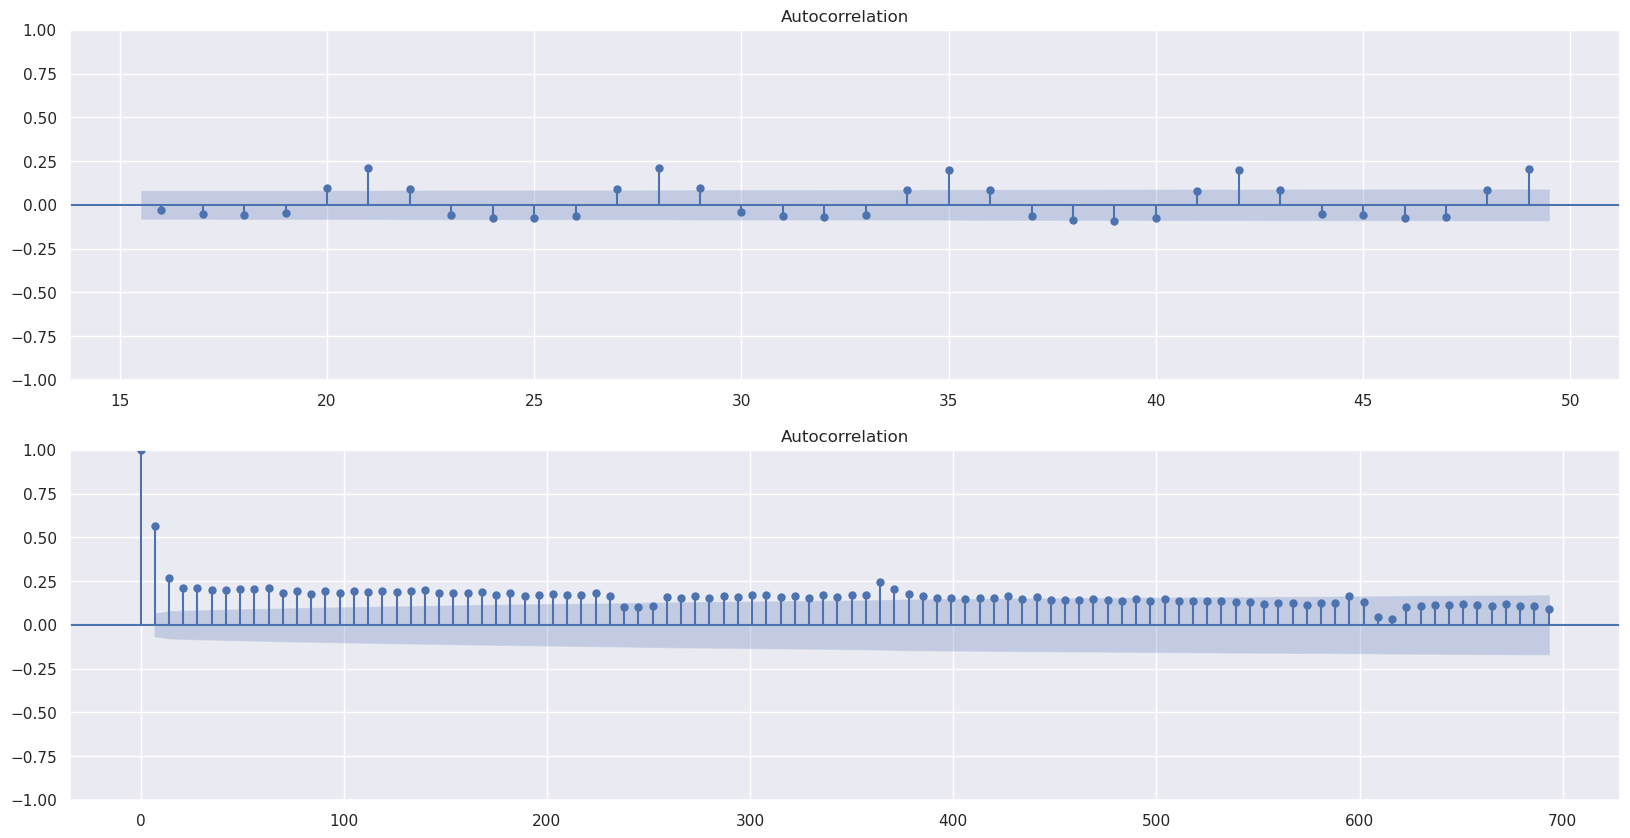

In [55]:
fig, ax = plt.subplots(2, figsize=(20, 10))

plot_acf(transactions_mean, lags=np.arange(16,50,1), alpha=0.05, ax=ax[0]);


plot_acf(transactions_mean, lags=np.arange(0,700,7), alpha=0.05, ax=ax[1]);
plt.show()

In [56]:
transaction_lags = [18,20,21,22,24,25,26,28,70,140,210,365]

In [57]:
for store in store_nbrs:

    store_family_index = transactions['store_nbr'] == store
    
    for lag in transaction_lags:

        transactions.loc[store_family_index,f'transactions-{lag}'] = transactions.loc[store_family_index,'transactions'].shift(lag)

In [58]:
transactions = transactions.drop(['transactions'], axis=1)
transactions = transactions.dropna()

## Stores 
* We will one-hot-encode the catagorical variables, but leaving the orignal columns for merging the data (will be dropped later on)

In [59]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [60]:
store_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

stores_encoded_array = store_encoder.fit_transform(stores[['city','state','type','cluster']])

stores = pd.concat([stores,stores_encoded_array], axis=1)

stores = stores.drop(['type'], axis=1)

In [61]:
stores.head()

,store_nbr,city,state,cluster,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,1,Quito,Pichincha,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,Quito,Pichincha,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,Quito,Pichincha,8,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Quito,Pichincha,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Santo Domingo,Santo Domingo de los Tsachilas,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Holidays Events
* Just look at national Holidays for now
* We need to deal with the transferred column. Currently the type for all of these is Tranfer, but we should set to the original holiday type for decisioning and just use the transferred flag as an indicator
* Create holiday_type from first word of description (need to strip off before '-' in some cases)
* We also have duplicate days with 2 different holidays so need to account for that
* We will one-hot-encode the catagorical variables, but leaving the orignal columns for merging the data (will be dropped later on)

In [62]:
# remove non-national holidays
holidays_events = holidays_events[holidays_events['locale'] == 'National']

In [63]:
## we've just got 8 transferred holidays to deal with
holidays_events[holidays_events['type'] == 'Transfer'].head(10)

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [64]:
# join original holiday onto transferred holiday by details
original_dates = holidays_events[holidays_events['transferred'] == True]
trasnferred_dates = holidays_events[holidays_events['type'] == 'Transfer']

original_dates['index'] = original_dates.index
trasnferred_dates['index'] = trasnferred_dates.index


full_merge = pd.merge(original_dates
                      ,trasnferred_dates
                      ,how='inner'
                      ,on=['locale','locale_name','description']
                      ,suffixes=('_original', '_transferred')
                     ).sort_values(by='date_original')

# calculate date diff to use in filter
full_merge['date_diff'] = (full_merge['date_transferred'] - full_merge['date_original']).dt.days

/tmp/ipykernel_20/730599835.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_dates['index'] = original_dates.index
/tmp/ipykernel_20/730599835.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trasnferred_dates['index'] = trasnferred_dates.index


In [65]:
# filter merge where transferred date is within a week of original date
transferred_merge = full_merge[(full_merge['date_diff'] <= 7) & (full_merge['date_diff'] > 0)]
transferred_merge.head(10)

,date_original,type_original,locale,locale_name,description,transferred_original,index_original,date_transferred,type_transferred,transferred_transferred,index_transferred,date_diff


In [66]:
# update Type of transferred date to the origial Type (in this case Holiday for all), and set transferred to True to indicate a moved date. Delete all of the origianl dates as they are more like normal days
holidays_events.loc[transferred_merge['index_transferred'], 'type'] = 'Holiday'
holidays_events.loc[transferred_merge['index_transferred'], 'transferred'] = 'True'

holidays_events = holidays_events.drop(transferred_merge['index_original'], axis=0)

In [67]:
# Take first word from description and use as a new feature - override original column since the rest isn't useful (just references locale_name)
holidays_events['description'] = holidays_events['description'].str.split(' ').str[0].str.split('-').str[0].str.split('+').str[0]

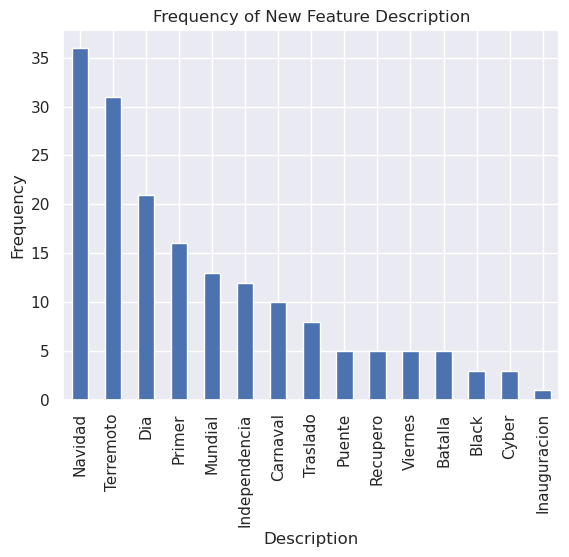

In [68]:
holidays_events['description'].value_counts().plot(kind='bar')

plt.title('Frequency of New Feature ''Description''')
plt.xlabel('Description')

plt.ylabel('Frequency')
plt.show()

### Dedupe National Holiday data
* some days have multiple rows for national holidays so encode all and then capture the duplicate rows data in one set of encoded columns

In [69]:
# We also have some dates that have multiple natinal holidays entries which could duplicate rows when concatenated
# Solution is to one hot encode rows and take max of encoded columns so we can account for having multiple holiday data in the same row
holidays_dupe_flag = (holidays_events.groupby('date')['type'].count() > 1)
holidays_events = holidays_events.merge(holidays_dupe_flag, how='left', on='date').sort_values(by=['date','type_x'])

holidays_events = holidays_events.rename(columns={'type_x':'type'
                                          ,'type_y':'dupe_flag'})

In [70]:
holidays_events

,date,type,locale,locale_name,description,transferred,dupe_flag
0,2012-08-10,Holiday,National,Ecuador,Primer,False,False
1,2012-10-09,Holiday,National,Ecuador,Independencia,True,False
2,2012-10-12,Transfer,National,Ecuador,Traslado,False,False
3,2012-11-02,Holiday,National,Ecuador,Dia,False,False
4,2012-11-03,Holiday,National,Ecuador,Independencia,False,False
...,...,...,...,...,...,...,...
169,2017-12-22,Additional,National,Ecuador,Navidad,False,False
170,2017-12-23,Additional,National,Ecuador,Navidad,False,False
171,2017-12-24,Additional,National,Ecuador,Navidad,False,False
172,2017-12-25,Holiday,National,Ecuador,Navidad,False,False


In [71]:
# view duped national holidays 
holidays_events[holidays_events['dupe_flag'] == True]

,date,type,locale,locale_name,description,transferred,dupe_flag
9,2012-12-24,Additional,National,Ecuador,Navidad,False,True
8,2012-12-24,Bridge,National,Ecuador,Puente,False,True
13,2012-12-31,Additional,National,Ecuador,Primer,False,True
12,2012-12-31,Bridge,National,Ecuador,Puente,False,True
72,2014-12-26,Additional,National,Ecuador,Navidad,False,True
71,2014-12-26,Bridge,National,Ecuador,Puente,False,True
117,2016-05-01,Event,National,Ecuador,Terremoto,False,True
116,2016-05-01,Holiday,National,Ecuador,Dia,False,True
123,2016-05-07,Additional,National,Ecuador,Dia,False,True
124,2016-05-07,Event,National,Ecuador,Terremoto,False,True


In [72]:
holiday_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

holiday_encoded = holiday_encoder.fit_transform(holidays_events[['type','locale','locale_name','description']])

holidays_events = pd.concat([holidays_events,holiday_encoded], axis=1)

holidays_events = holidays_events.drop(['type','locale','description'], axis=1)

In [73]:
## remove dupe rows, tranform and then re-insert
holidays_events_dupes = holidays_events[holidays_events['dupe_flag'] == 1]

holidays_events = holidays_events.drop(holidays_events_dupes.index, axis=0)

holidays_events.shape

(162, 27)

In [74]:
holiday_dupes_deduped = holidays_events_dupes.groupby(['date']).max().reset_index()

In [75]:
holidays_events = pd.concat([holidays_events,holiday_dupes_deduped], axis=0)
holidays_events = holidays_events.drop(['dupe_flag'], axis=1)

/tmp/ipykernel_20/3284737960.py:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  holidays_events = pd.concat([holidays_events,holiday_dupes_deduped], axis=0)


## Oil
* Need to fill na columns
* we're missing some dates from the dataset (e.g. 5th Jan 2013) so we need to create the correct data range and work from that to fill na values
* use a 5 day moving average to impute null values


In [76]:
train_start = train['date'].min()
train_end = train['date'].max()
test_start = test['date'].min()
test_end = test['date'].max()

date_range = pd.DataFrame(pd.date_range(start=train_start, end=test_end), columns=['date'])

In [77]:
oil = date_range.merge(oil, how='left', left_on=['date'], right_on=['date'])

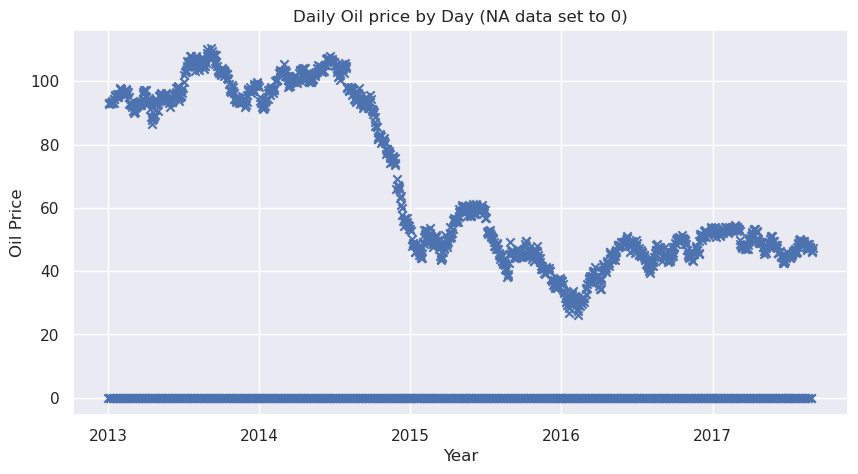

In [78]:
oil['date'] = oil['date'].astype('datetime64[ns]')
plt.figure(figsize=(10,5))
plt.scatter(oil['date'], oil['dcoilwtico'].fillna(0), marker='x')

plt.xlabel('Year')
plt.ylabel('Oil Price')
plt.title('Daily Oil price by Day (NA data set to 0)')
plt.show()

In [79]:
# fill na columns with 5 day rolling average centred on the point
oil_na_mask = oil['dcoilwtico'].isna()

oil['dcoilwtico'] = oil['dcoilwtico'].fillna(oil['dcoilwtico'].rolling(5, center=True, min_periods=1).mean())

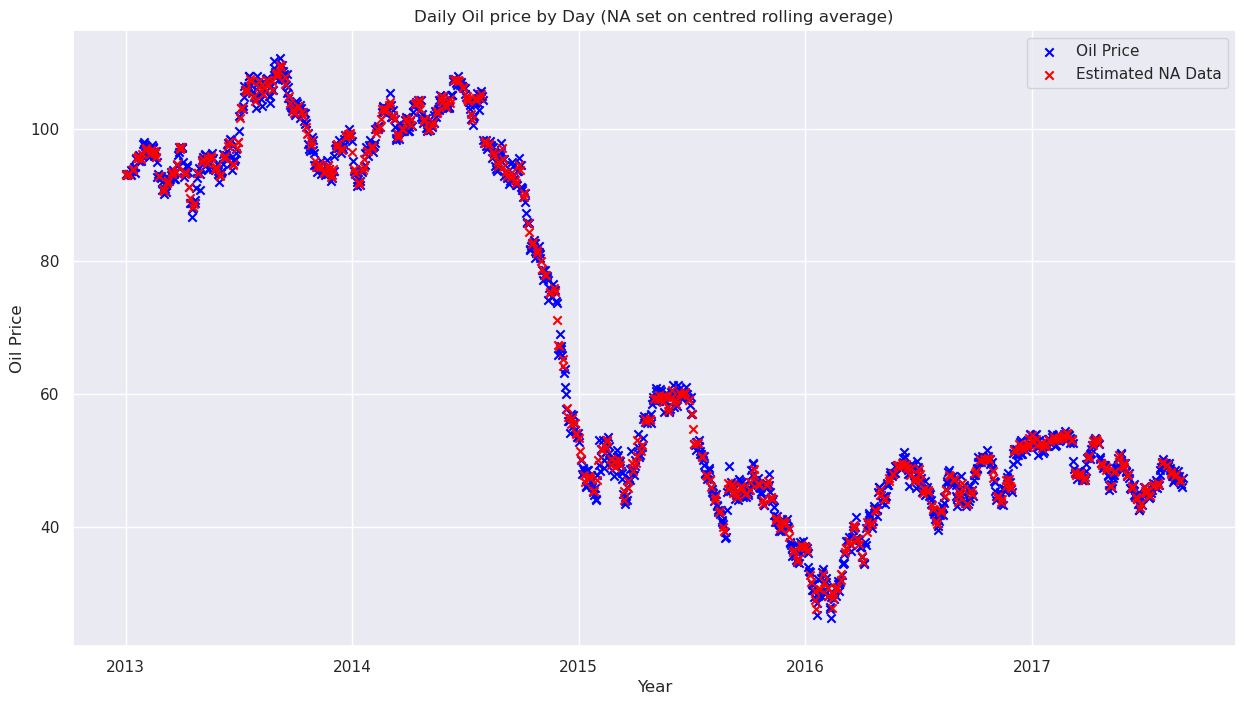

In [80]:
plt.figure(figsize=(15,8))
plt.scatter(oil[~oil_na_mask]['date'], oil[~oil_na_mask]['dcoilwtico'], color='blue', marker='x', label='Oil Price')
plt.scatter(oil[oil_na_mask]['date'], oil[oil_na_mask]['dcoilwtico'], color='red', marker='x', label='Estimated NA Data')

plt.xlabel('Year')
plt.ylabel('Oil Price')
plt.title('Daily Oil price by Day (NA set on centred rolling average)')
plt.legend()
plt.show()


# Concatenate all DataFrames for Training


In [81]:
#  merge train, oil & stores
print(train_test.shape)
train_test = train_test.merge(oil, how='left', on='date')
print(train_test.shape)
train_test = train_test.merge(stores, left_on=['store_nbr'], right_on=['store_nbr'], suffixes = ['_store', '_holiday'])
print(train_test.shape)
train_test = train_test.merge(transactions, left_on=['date','store_nbr'], right_on=['date','store_nbr'])
print(train_test.shape) # should drop due to removing date that can't have lags

(3029400, 20)
(3029400, 21)
(3029400, 84)
(2380752, 96)


In [82]:
train_test = train_test.merge(holidays_events, how='left', left_on=['date'], right_on=['date'], suffixes = [None, '_national'])
train_test = train_test.drop(['locale_name','city','state'], axis=1)
train_test['transferred'] = train_test['transferred'].astype('bool')

print(train_test.shape)

(2380752, 118)


## Final Adjustments
* remove date from disaster period since data isn't representative (2016-04-16)
* fill na data (from holiday columns) with 0 where no merge was found
* set index to date column

In [83]:
## look at total sales by day 3 months before and after period to see when level were back to normal
period_mask = (train_test['date'].dt.date >= datetime.date(2016,1,15)) & (train_test['date'].dt.date < datetime.date(2016,8,15))

train_test_disaster = train_test[period_mask]

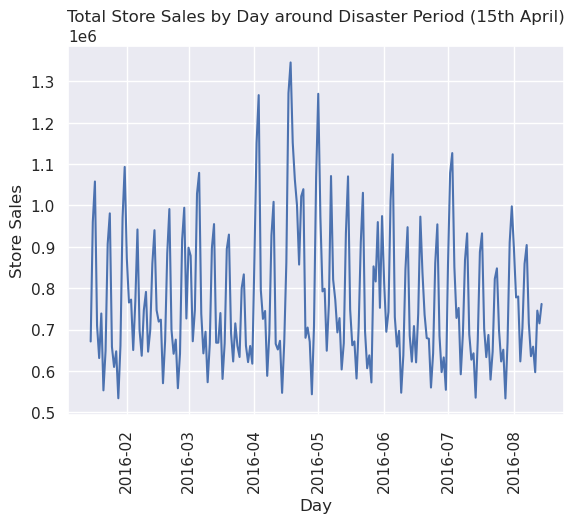

In [84]:
## volumes seem to normalise within approx 1 month - remove data from that period
disater_period_sales = train_test_disaster.groupby('date')['sales'].sum()

plt.plot(disater_period_sales)
plt.ylabel('Store Sales')
plt.xlabel('Day')
plt.xticks(rotation=90)
plt.title('Total Store Sales by Day around Disaster Period (15th April)')
plt.show()

In [85]:
period_mask = (train_test['date'].dt.date >= datetime.date(2016,5,15)) & (train_test['date'].dt.date < datetime.date(2016,5,15) + datetime.timedelta(weeks=4))

train_test = train_test[~period_mask]

In [86]:
# fill holiday NA columns with 0
train_test = train_test.fillna(0)

In [87]:
train_test.index = train_test['date']
train_test = train_test.drop(['date'], axis=1)

In [88]:
store_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

train_test_encoded_array = store_encoder.fit_transform(train_test[['store_nbr']])

train_test = pd.concat([train_test,train_test_encoded_array], axis=1)

train_test = train_test.drop(['store_nbr'], axis=1)

# Split into Test,Train and Submissions Sets

In [89]:
train_index_min = train['id'].min()
train_index_max = train['id'].max()
test_index_min = test['id'].min()
test_index_max = test['id'].max()

In [90]:
X_train = train_test[(train_test['id'] >=train_index_min) & (train_test['id'] <= train_index_max)]
X_submission = train_test[(train_test['id'] >=test_index_min) & (train_test['id'] <= test_index_max)]

In [91]:
# clear train_test from memory
train_test = []

In [92]:
y_train = X_train['sales'].copy()
X_train = X_train.drop(['sales'], axis=1)
X_submission = X_submission.drop(['sales'], axis=1)

In [93]:
X_train_id = X_train['id']
X_submission_id = X_submission['id']

X_train = X_train.drop(['id'], axis=1)
X_submission = X_submission.drop(['id'], axis=1)

In [94]:
X_test = X_train.loc['2017-07-01':'2017-08-15',:]
X_train = X_train.loc['2013-01-01':'2017-06-30',:]

/tmp/ipykernel_20/1944631483.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  X_train = X_train.loc['2013-01-01':'2017-06-30',:]


In [95]:
y_test = y_train.loc['2017-07-01':'2017-08-15']
y_train = y_train.loc['2013-01-01':'2017-06-30']

/tmp/ipykernel_20/59402216.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  y_train = y_train.loc['2013-01-01':'2017-06-30']


# Train Model - Model Per Product
* Train and store down model for each product family

In [96]:
# train model & store accurcies per product familu
y_pred = y_test.copy()
y_pred[:] = 0

family_models = {}
product_accuracy = np.zeros(len(product_families))

for n, p_f in enumerate(product_families):
    
    # train model
    model = LGBMRegressor()
        
    train_family_mask = X_train['family'] == p_f
    
    model.fit(X_train[train_family_mask].drop('family', axis=1), y_train[train_family_mask])
    
    
    # test model
    test_family_mask = X_test['family'] == p_f
    
    y_pred[test_family_mask] = model.predict(X_test[test_family_mask].drop('family', axis=1))
    
    y_pred[y_pred < 0] = 0
    
    # calculate msle
    msle = mean_squared_log_error(y_test[test_family_mask], y_pred[test_family_mask])
    product_accuracy[n] = msle
    
    # save model
    family_models[p_f] = model

    print(f'Trained Model for Family {p_f} with a MSLE of {msle}')

Trained Model for Family AUTOMOTIVE with a MSLE of 0.2748265711969642
Trained Model for Family BABY CARE with a MSLE of 0.10259259443334603
Trained Model for Family BEAUTY with a MSLE of 0.24951538350812755
Trained Model for Family BEVERAGES with a MSLE of 0.04595337759432823
Trained Model for Family BOOKS with a MSLE of 0.013916672030311428
Trained Model for Family BREAD/BAKERY with a MSLE of 0.02874281668687523
Trained Model for Family CELEBRATION with a MSLE of 0.3395894837543239
Trained Model for Family CLEANING with a MSLE of 0.08906871462373897
Trained Model for Family DAIRY with a MSLE of 0.01998150167032726
Trained Model for Family DELI with a MSLE of 0.031545585734334004
Trained Model for Family EGGS with a MSLE of 0.09700867770795545
Trained Model for Family FROZEN FOODS with a MSLE of 0.07954785372509363
Trained Model for Family GROCERY I with a MSLE of 0.022927425352310276
Trained Model for Family GROCERY II with a MSLE of 0.4034259874935098
Trained Model for Family HARDWAR

In [97]:
msle = mean_squared_log_error(y_test, y_pred)

print(f'Overall Mean Squared Log Error on Test set is : {msle:.4f}')

Overall Mean Squared Log Error on Test set is : 0.1808


# Review Results
* View predicitons on test set vs actual test set data
* Check MSLE across stores and product familys to check for outliers
* sense check example preditions to submission set

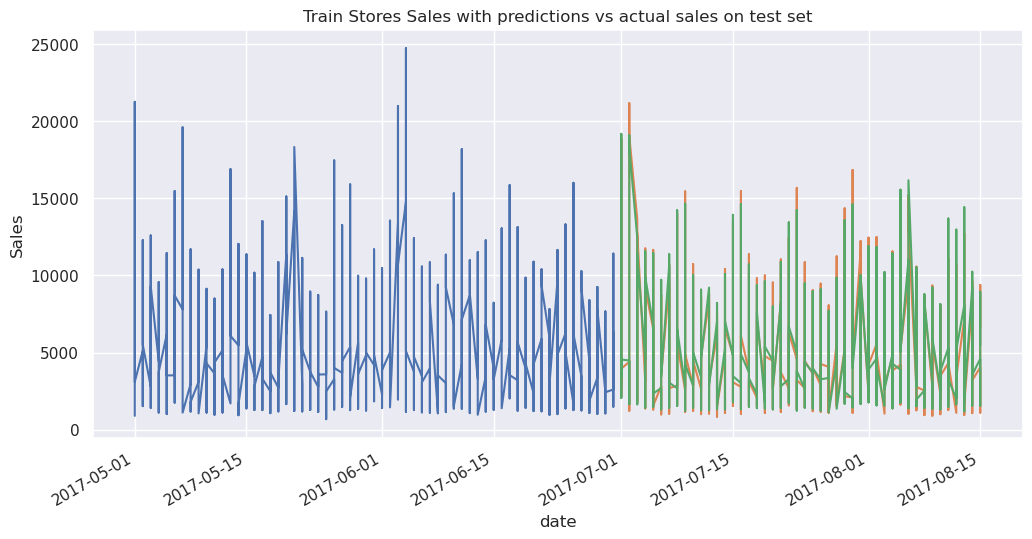

In [98]:
# look at predictions for books to sense check accuracy
train_family_mask = X_train['family'] == 'GROCERY I'
test_family_mask = X_test['family'] == 'GROCERY I'

plt.figure(figsize=(12,6))
y_train[train_family_mask].loc['2017-05-01':].plot()
y_test[test_family_mask].plot()
y_pred[test_family_mask].plot()

plt.title('Train Stores Sales with predictions vs actual sales on test set')
plt.ylabel('Sales')

plt.show()

### Check MSLE across stores and product familys to check for outliers

In [99]:
store_accuracy = np.zeros(len(store_nbrs))

for n, store in enumerate(store_nbrs):
    
    store_mask = X_test['store_nbr_'+str(store)] == 1
    
    msle = mean_squared_log_error(y_test[store_mask], y_pred[store_mask])
    
    store_accuracy[n] = msle

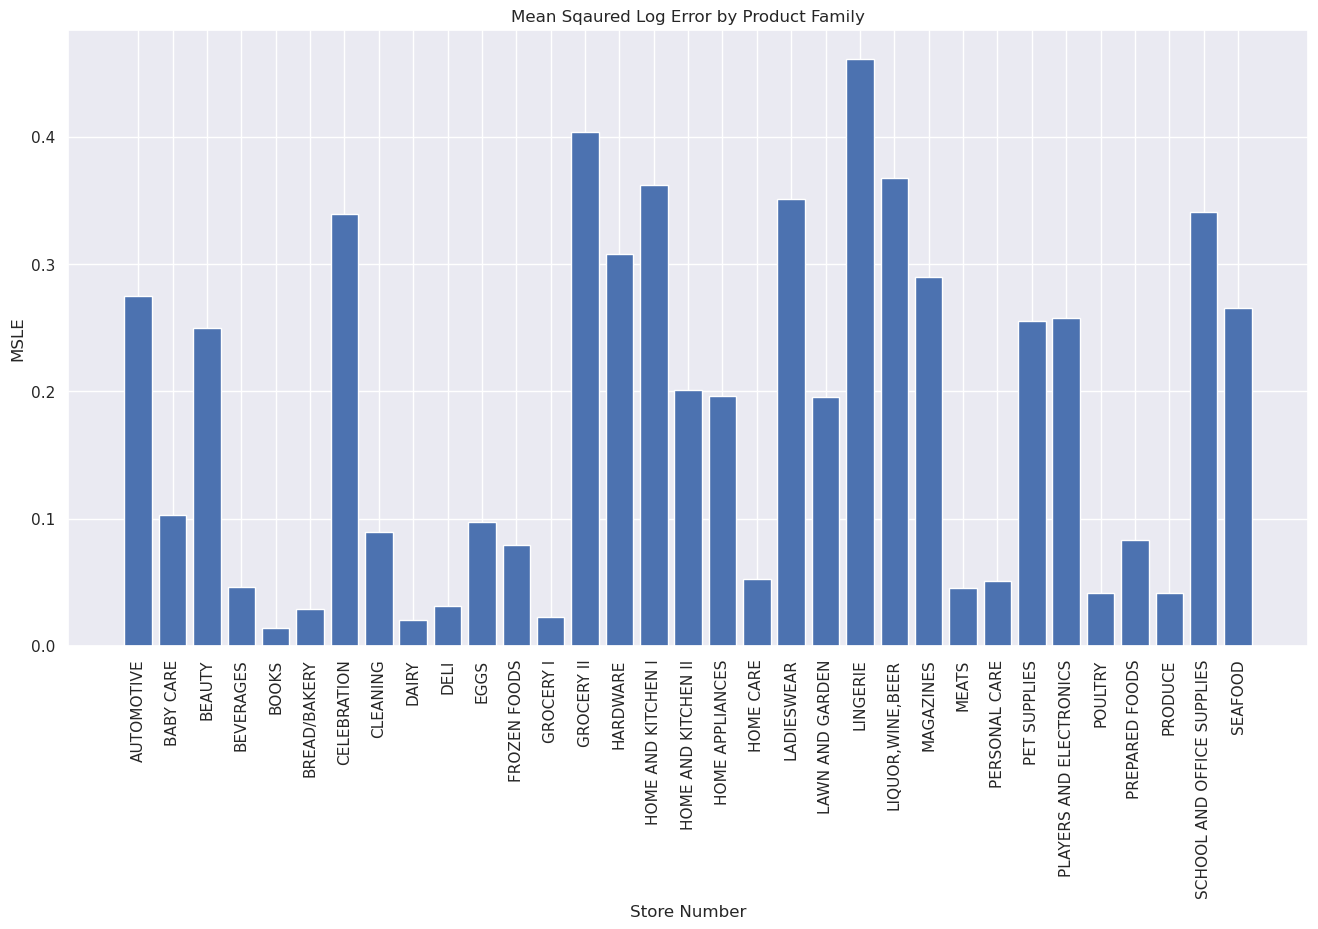

In [100]:
plt.figure(figsize=(16,8))

plt.bar(product_families,product_accuracy)

plt.xticks(rotation=90)

plt.xlabel('Store Number')
plt.ylabel('MSLE')

plt.title('Mean Sqaured Log Error by Product Family')
plt.show()

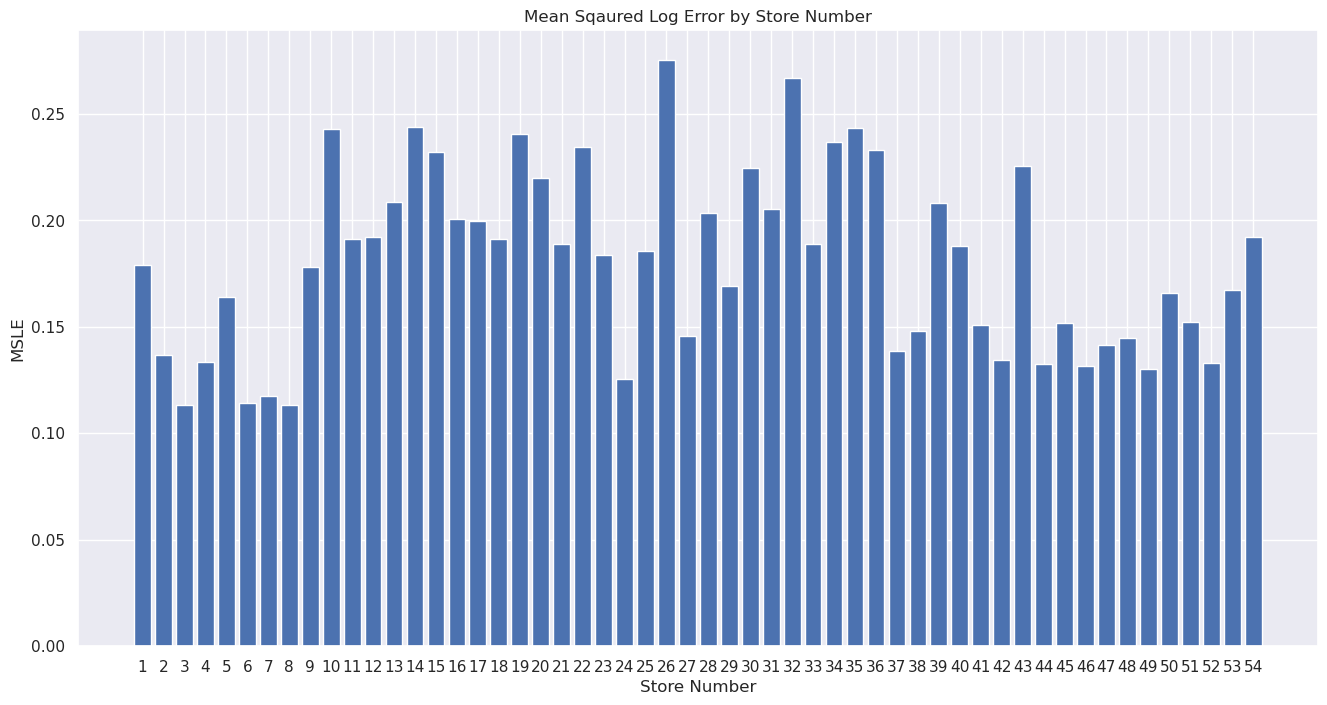

In [101]:
plt.figure(figsize=(16,8))

plt.bar(store_nbrs,store_accuracy)

plt.xticks(store_nbrs)

plt.xlabel('Store Number')
plt.ylabel('MSLE')

plt.title('Mean Sqaured Log Error by Store Number')
plt.show()

### Make Predictions

In [102]:
# functionable
y_submission_pred= pd.Series(data=0, index=X_submission.index)

for p_f in product_families:
    
    # train model
    model = family_models[p_f]    
    
    # make predictions
    submission_family_mask = X_submission['family'] == p_f
    
    y_submission_pred[submission_family_mask] = model.predict(X_submission[submission_family_mask].drop('family', axis=1))
        
    print(f'Made predictions of Family {p_f}')
    
y_submission_pred[y_submission_pred < 0] = 0
    

Made predictions of Family AUTOMOTIVE
Made predictions of Family BABY CARE
Made predictions of Family BEAUTY
Made predictions of Family BEVERAGES
Made predictions of Family BOOKS
Made predictions of Family BREAD/BAKERY
Made predictions of Family CELEBRATION
Made predictions of Family CLEANING
Made predictions of Family DAIRY
Made predictions of Family DELI
Made predictions of Family EGGS
Made predictions of Family FROZEN FOODS
Made predictions of Family GROCERY I
Made predictions of Family GROCERY II
Made predictions of Family HARDWARE
Made predictions of Family HOME AND KITCHEN I
Made predictions of Family HOME AND KITCHEN II
Made predictions of Family HOME APPLIANCES
Made predictions of Family HOME CARE
Made predictions of Family LADIESWEAR
Made predictions of Family LAWN AND GARDEN
Made predictions of Family LINGERIE
Made predictions of Family LIQUOR,WINE,BEER
Made predictions of Family MAGAZINES
Made predictions of Family MEATS
Made predictions of Family PERSONAL CARE
Made predicti

In [103]:
# look at predictions for books
train_family_mask = X_train['family'] == 'PRODUCE'
test_family_mask = X_test['family'] == 'PRODUCE'
submission_family_mask = X_submission['family'] == 'PRODUCE'

In [104]:
submission = pd.DataFrame(np.array([X_submission_id.values,y_submission_pred]).T, columns=['id', 'sales'], dtype=(int, float))

/tmp/ipykernel_20/2582883156.py:1: FutureWarning: In a future version, passing float-dtype values and an integer dtype to DataFrame will retain floating dtype if they cannot be cast losslessly (matching Series behavior). To retain the old behavior, use DataFrame(data).astype(dtype)
  submission = pd.DataFrame(np.array([X_submission_id.values,y_submission_pred]).T, columns=['id', 'sales'], dtype=(int, float))


### Sense check Submision Predictions

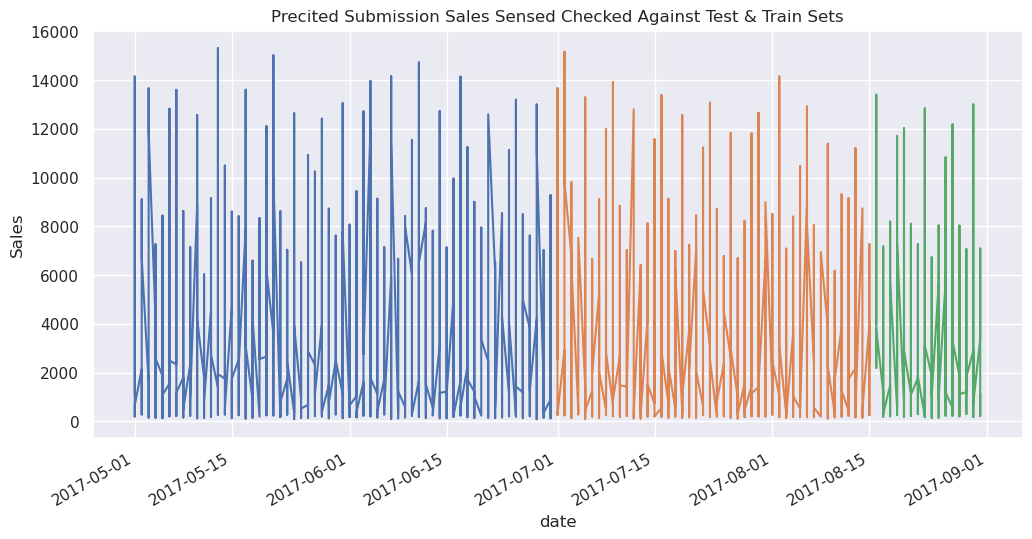

In [105]:
plt.figure(figsize=(12,6))
y_train[train_family_mask].loc['2017-05-01':].plot()
y_test[test_family_mask].plot()
y_submission_pred[submission_family_mask].plot()

plt.title('Precited Submission Sales Sensed Checked Against Test & Train Sets')
plt.ylabel('Sales')
plt.show()

In [106]:
submission.to_csv('store_sales_submission.csv',index = False)

# Posible Improvements
* Use all holiday features and group similar holidays
* Create windowed lag featues
* Look into worst performing product families and identify what might improve them